In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve,fbeta_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import math
import random
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

import shap

import joblib
from joblib import dump

import pickle

In [2]:
pd.set_option("max_rows", None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [3]:
SEED = np.random.seed(5)
cv_train = KFold(n_splits = 5, shuffle = True, random_state = SEED)
score = ('r2','neg_mean_absolute_error')

# Modélisation

Maintenant que nous avons nos datasets finaux nous allons nous intéresser à différents modèles, pour ces modèles nous utiliserons HyperOpt et GridSearchCV afin d'optimiser ces derniers, nous allons donc charger cette bibliothèque dans un premier temps:

In [4]:
#!pip install hyperopt
from hyperopt import hp

Dans un premier temps chargons les datasets train_data, test_data et target_train que l'on récupérera de la partie Feature Engeneering précèdente. Nos datasets sont déjà réduits en utilisant la RFE (Recursive Feature Elimination) et plus particulièrement LightGBM.

In [5]:
train_data = joblib.load(r'C:\Users\Alexis\train_dataID.joblib')
test_data = joblib.load(r'C:\Users\Alexis\test_dataID.joblib')

In [6]:
train_data.shape

(307507, 1112)

In [7]:
train_data.head(5)

CNT_INSTALMENT_MEAN_YEAR_0_MAX  CNT_PAYMENT_MEAN_ALL  \
0                       24.000000             24.000000   
1                             NaN             10.000000   
2                             NaN              4.000000   
3                       16.671875             23.000000   
4                       24.000000             20.671875   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL_INCOME_RATIO  \
0                                                 0.008301   
1                                                 0.000000   
2                                                 0.000000   
3                                                      NaN   
4                                                 0.000000   

   EXT_SOURCE_MEAN_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                 0.830078   
1                                                                 0.829102   
2                                                                 0.830078   
3                                                                 0.808594   
4                                                                 0.830078   

   CURRENT_DEBT_TO_CREDIT_RATIO_MIN_CREDITACTIVE_ACTIVE  \
0                                                   0.0   
1                                                   0.0   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   

   PRODUCT_COMBINATION_MEAN_ALL  YEARS_BUILD_MODE  \
0                      2.000000          0.634277   
1                      4.000000          0.804199   
2                      6.000000               NaN   
3                      6.445312               NaN   
4                      8.164062               NaN   

   PAYMENT_MIN_DIFF_MIN_YEAR_0  NAME_CASH_LOAN_PURPOSE_LAST_FIRST_2  \
0                          NaN                                  1.0   
1                          NaN                                  1.0   
2                          NaN                                  1.0   
3                          0.0                                  1.0   
4                          NaN                                  1.0   

   INTEREST_DOWNPAYMENT_MEAN_LAST_5  \
0                          0.000000   
1                        344.458588   
2                       1030.356934   
3                               NaN   
4                        310.943878   

   AMT_ANNUITY_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             1980.0   
1                                                             3595.5   
2                                                             2205.0   
3                                                             1980.0   
4                                                             1980.0   

   WEIGHTED_STATUS_MEAN_YEAR_0_MEAN_OVERALL  TOTAL_TERM_MAX_YEAR_0_MEAN  \
0                                  0.119812                        40.0   
1                                       NaN                         NaN   
2                                       NaN                         NaN   
3                                       NaN                        60.0   
4                                       NaN                        32.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                                                          1.025391   
1                                                                          1.352539   
2                                                                          1.025391   
3                                                                          1.025391   
4                                                                          1.079102   

   AMT_PAYMENT_DIFF_MIN_LAST_1_YEAR  HOUR_APPR_PROCESS_START_ME

In [8]:
test_data.shape

(48744, 1112)

In [9]:
test_data.head(5)

CNT_INSTALMENT_MEAN_YEAR_0_MAX  CNT_PAYMENT_MEAN_ALL  \
0                             NaN              8.000000   
1                             NaN             12.000000   
2                            17.0             17.328125   
3                             NaN             11.335938   
4                             NaN             24.000000   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL_INCOME_RATIO  \
0                                                      NaN   
1                                                 0.000000   
2                                                 0.095333   
3                                                 0.000000   
4                                                      NaN   

   EXT_SOURCE_MEAN_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                 0.853516   
1                                                                 0.828613   
2                                                                 0.828613   
3                                                                 0.853516   
4                                                                 0.828613   

   CURRENT_DEBT_TO_CREDIT_RATIO_MIN_CREDITACTIVE_ACTIVE  \
0                                              0.335128   
1                                              0.848974   
2                                                   NaN   
3                                              0.000000   
4                                                   NaN   

   PRODUCT_COMBINATION_MEAN_ALL  YEARS_BUILD_MODE  \
0                      1.000000               NaN   
1                      4.000000               NaN   
2                      5.500000               NaN   
3                      6.398438          0.960938   
4                      6.000000               NaN   

   PAYMENT_MIN_DIFF_MIN_YEAR_0  NAME_CASH_LOAN_PURPOSE_LAST_FIRST_2  \
0                          NaN                                  1.0   
1                          NaN                                  2.0   
2                          0.0                                  2.0   
3                          0.0                                  1.0   
4                          NaN                                  2.0   

   INTEREST_DOWNPAYMENT_MEAN_LAST_5  \
0                        262.902008   
1                        486.415344   
2                        453.713196   
3                        649.216431   
4                        708.790222   

   AMT_ANNUITY_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             1980.0   
1                                                             1980.0   
2                                                             2204.0   
3                                                             1980.0   
4                                                             2318.0   

   WEIGHTED_STATUS_MEAN_YEAR_0_MEAN_OVERALL  TOTAL_TERM_MAX_YEAR_0_MEAN  \
0                                  0.314941                         NaN   
1                                  0.711914                         NaN   
2                                  0.258545                        14.5   
3                                  0.404297                         NaN   
4                                       NaN                         NaN   

   APARTMENTS_SUM_MEDI_MIN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                                                          0.907715   
1                                                                          1.397461   
2                                                                          1.374023   
3                                                                          1.176758   
4                                                                          0.476807   

   AMT_PAYMENT_DIFF_MIN_LAST_1_YEAR  HOUR_APPR_PROCESS_START_ME

In [10]:
target_train = pd.read_csv('target_trainF.csv')

In [11]:
joblib.dump(target_train, r'C:\Users\Alexis\target_train.joblib')

['C:\\Users\\Alexis\\target_train.joblib']

In [12]:
target_train.shape

(307507, 1)

In [13]:
target_train.head(5)

TARGET
0       1
1       0
2       0
3       0
4       0

Avant de continuer nous allons remplacer les valeurs manquantes puis standardiser nos données.

Nous commencerons par les valeurs manquantes, nous allons regarder le taux de complétion des variables:

In [14]:
#DataNaN = train_data.isna().sum().divide(train_data.shape[0]).multiply(100).sort_values(ascending = True)
#    
#plt.figure(figsize=(15, 200))
#sns.barplot(x = DataNaN.values, y = DataNaN.index)
#plt.xlabel('Taux de données manquante (en %)', fontsize = 15)
#plt.ylabel('Nom de la variable', fontsize = 15)
#plt.title('Taux de données manquantes par variable dans le dataset (en %)', fontsize = 20)
#plt.tick_params(axis='x', which='major', labelsize=15)
#plt.tick_params(axis='y', which='major', labelsize=10)
#plt.show()

Pour la suite nous ne garderons que les variables avec moins de 60% de valeurs manquantes, au dessus nous n'aurons pas assez de valeurs pour avoir des valeurs de moyenne ou médiane qui colle vraiment à ce que nous avons et ça n'apportera pas d'infos au final.

In [15]:
def tauxDeNan_Affichage(dataset, variable):
    print('La variable', variable, 'contient', round((dataset[variable].isna().sum()/dataset.shape[0]) * 100, 2), '% de données manquantes.')


def tauxDeNan(dataset, variable):
    return round((dataset[variable].isna().sum()/dataset.shape[0])*100, 2)

In [16]:
listeVariableADrop = []

In [17]:
for variable in train_data.columns:
    if tauxDeNan(train_data, variable) > 60:
        listeVariableADrop.append(variable)

In [18]:
len(listeVariableADrop)

158

In [19]:
train_data.drop(listeVariableADrop, axis = 1, inplace = True)

In [20]:
train_data.head(5)

CNT_INSTALMENT_MEAN_YEAR_0_MAX  CNT_PAYMENT_MEAN_ALL  \
0                       24.000000             24.000000   
1                             NaN             10.000000   
2                             NaN              4.000000   
3                       16.671875             23.000000   
4                       24.000000             20.671875   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL_INCOME_RATIO  \
0                                                 0.008301   
1                                                 0.000000   
2                                                 0.000000   
3                                                      NaN   
4                                                 0.000000   

   EXT_SOURCE_MEAN_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                 0.830078   
1                                                                 0.829102   
2                                                                 0.830078   
3                                                                 0.808594   
4                                                                 0.830078   

   CURRENT_DEBT_TO_CREDIT_RATIO_MIN_CREDITACTIVE_ACTIVE  \
0                                                   0.0   
1                                                   0.0   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   

   PRODUCT_COMBINATION_MEAN_ALL  NAME_CASH_LOAN_PURPOSE_LAST_FIRST_2  \
0                      2.000000                                  1.0   
1                      4.000000                                  1.0   
2                      6.000000                                  1.0   
3                      6.445312                                  1.0   
4                      8.164062                                  1.0   

   INTEREST_DOWNPAYMENT_MEAN_LAST_5  \
0                          0.000000   
1                        344.458588   
2                       1030.356934   
3                               NaN   
4                        310.943878   

   AMT_ANNUITY_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             1980.0   
1                                                             3595.5   
2                                                             2205.0   
3                                                             1980.0   
4                                                             1980.0   

   TOTAL_TERM_MAX_YEAR_0_MEAN  \
0                        40.0   
1                         NaN   
2                         NaN   
3                        60.0   
4                        32.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                                                          1.025391   
1                                                                          1.352539   
2                                                                          1.025391   
3                                                                          1.025391   
4                                                                          1.079102   

   AMT_PAYMENT_DIFF_MIN_LAST_1_YEAR  HOUR_APPR_PROCESS_START_MEAN_LAST_5  \
0                               0.0                             9.000000   
1                               NaN                            14.664062   
2                               NaN                             5.000000   
3                               0.0                            14.398438   
4                               0.0                            12.203125   

   AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0   
1                        0.0   
2                        0.0   
3                        NaN   
4          

Enlevons ces mêmes variables à test_data, afin que nous puissions utiliser la table par la suite (afin qu'il n'y ait pas de problème de nombre de variable):  

In [21]:
test_data.drop(listeVariableADrop, axis = 1, inplace = True)

In [22]:
test_data.shape

(48744, 954)

Nous allons maintenant regarder les outliers, en fonction de ça nous appliquerons soit la moyenne, soit la médianne en remplacement des valeurs manquantes.

In [23]:
for column in train_data.columns:
    if train_data[column].dtypes == 'int8' or train_data[column].dtypes == 'int16' or train_data[column].dtypes == 'int32':
        train_data[column] = train_data[column].astype('int64')
    elif train_data[column].dtypes == 'float16' or train_data[column].dtypes == 'float32':
        train_data[column] = train_data[column].astype('float64')

In [24]:
train_data['SK_ID_CURR'] = train_data['SK_ID_CURR'].astype('object')
#train_data['CNT_CHILDREN'] = train_data['CNT_CHILDREN'].astype('object')

In [25]:
colonneNumériqueTrain = train_data.select_dtypes(['int64','float64']).columns
colonneNumériqueTest = test_data.select_dtypes(['int64','float64']).columns

In [26]:
listeVariableAvecNaN = []

In [27]:
for variable in train_data[colonneNumériqueTrain].columns:
    if tauxDeNan(train_data, variable) > 0:
        listeVariableAvecNaN.append(variable)

In [28]:
len(listeVariableAvecNaN)

743

In [29]:
#for variable in listeVariableAvecNaN:
#    sns.boxplot(x = train_data[variable])
#    plt.show()

Pour les variables qui possédant des outliers nous utiliserons la médiane comme remplacement des valeurs manquantes, pour les autres variables nous utiliserons la moyenne.

Il existe des moyens automatique pour la recherche des oultiers, comme l'intervalle inter-quartile notamment, mais pour être sûr du résultat, j'ai préféré regarder moi même les boxplots.

In [30]:
listeVariableMoyenne = ['NAME_YIELD_GROUP_MEAN_LAST_5', 'NAME_YIELD_GROUP_MEAN_FIRST_2', 'WEEKDAY_APPR_PROCESS_START_MEAN_ALL', 'DAYS_CREDIT_MEAN_CREDITACTIVE_CLOSED', 'CREDIT_TYPE_Consumer credit_MEAN_OVERALL', 'INTEREST_SHARE_MIN_LAST_5', 'CREDIT_ACTIVE_Closed_MEAN_OVERALL', 'NAME_CONTRACT_STATUS_MAX_LAST_5', 'DAYS_LAST_DUE_1ST_VERSION_MEAN_FIRST_2', 'NAME_YIELD_GROUP_MEAN_ALL', 'NAME_CLIENT_TYPE_MEAN_LAST_5', 'INTEREST_RATE_MIN_ALL', 'INTEREST_SHARE_MIN_ALL', 'DAYS_DECISION_MIN_LAST_5', 'WEEKDAY_APPR_PROCESS_START_MAX_LAST_5', 'DAYS_DECISION_MIN_FIRST_2', 'PRODUCT_COMBINATION_LAST_LAST_5', 'DAYS_LAST_DUE_MEAN_FIRST_2', 'NAME_CLIENT_TYPE_MEAN_ALL', 'DAYS_DECISION_MIN_ALL', 'DAYS_DECISION_MEAN_FIRST_2', 'NAME_PRODUCT_TYPE_LAST_FIRST_2', 'DAYS_CREDIT_LAST_CREDITACTIVE_CLOSED', 'DAYS_FIRST_DUE_MEAN_FIRST_2', 'NAME_YIELD_GROUP_LAST_FIRST_2', 'DAYS_FIRST_DUE_MAX_FIRST_2', 'WEEKDAY_APPR_PROCESS_START_MIN_LAST_5', 'DAYS_TERMINATION_MEAN_FIRST_2',  'INTEREST_RATE_MIN_LAST_5', 'DAYS_CREDIT_MIN_CREDITACTIVE_CLOSED', 'DAYS_DECISION_MAX_FIRST_2',  'CREDIT_ACTIVE_Active_MEAN_OVERALL', 'DAYS_TERMINATION_MAX_FIRST_2', 'MISSING_VALUES_TOTAL_PREV_SUM_LAST_5', 'NAME_CONTRACT_STATUS_LAST_LAST_5', 'WEEKDAY_APPR_PROCESS_START_MEAN_LAST_5', 'NAME_PORTFOLIO_LAST_LAST_5',  'NFLAG_INSURED_ON_APPROVAL_SUM_FIRST_2', 'PRODUCT_COMBINATION_LAST_FIRST_2', 'WEEKDAY_APPR_PROCESS_START_MIN_FIRST_2', 'NAME_CONTRACT_STATUS_MEAN_LAST_5', 'NAME_YIELD_GROUP_LAST_LAST_5', 'WEEKDAY_APPR_PROCESS_START_MEAN_FIRST_2']

In [31]:
listeVariableTrainData = train_data[colonneNumériqueTrain].columns.tolist()

In [32]:
len(listeVariableTrainData)

944

In [33]:
listeVariableMédianne = listeVariableTrainData
for elt in listeVariableMoyenne:
    if elt in listeVariableMédianne:
        listeVariableMédianne.remove(elt)
    else:
        continue

In [34]:
for variable in listeVariableMoyenne:
    train_data[variable].fillna(value = train_data[variable].mean(), inplace=True) 

In [35]:
for variable in listeVariableMédianne:
    train_data[variable].fillna(value = train_data[variable].median(), inplace=True) 

In [36]:
train_data.head(5)

CNT_INSTALMENT_MEAN_YEAR_0_MAX  CNT_PAYMENT_MEAN_ALL  \
0                       24.000000             24.000000   
1                       16.000000             10.000000   
2                       16.000000              4.000000   
3                       16.671875             23.000000   
4                       24.000000             20.671875   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL_INCOME_RATIO  \
0                                                 0.008301   
1                                                 0.000000   
2                                                 0.000000   
3                                                 0.000000   
4                                                 0.000000   

   EXT_SOURCE_MEAN_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                 0.830078   
1                                                                 0.829102   
2                                                                 0.830078   
3                                                                 0.808594   
4                                                                 0.830078   

   CURRENT_DEBT_TO_CREDIT_RATIO_MIN_CREDITACTIVE_ACTIVE  \
0                                              0.000000   
1                                              0.000000   
2                                              0.256528   
3                                              0.256528   
4                                              0.256528   

   PRODUCT_COMBINATION_MEAN_ALL  NAME_CASH_LOAN_PURPOSE_LAST_FIRST_2  \
0                      2.000000                                  1.0   
1                      4.000000                                  1.0   
2                      6.000000                                  1.0   
3                      6.445312                                  1.0   
4                      8.164062                                  1.0   

   INTEREST_DOWNPAYMENT_MEAN_LAST_5  \
0                          0.000000   
1                        344.458588   
2                       1030.356934   
3                        308.267181   
4                        310.943878   

   AMT_ANNUITY_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             1980.0   
1                                                             3595.5   
2                                                             2205.0   
3                                                             1980.0   
4                                                             1980.0   

   TOTAL_TERM_MAX_YEAR_0_MEAN  \
0                        40.0   
1                        24.0   
2                        24.0   
3                        60.0   
4                        32.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                                                          1.025391   
1                                                                          1.352539   
2                                                                          1.025391   
3                                                                          1.025391   
4                                                                          1.079102   

   AMT_PAYMENT_DIFF_MIN_LAST_1_YEAR  HOUR_APPR_PROCESS_START_MEAN_LAST_5  \
0                               0.0                             9.000000   
1                               0.0                            14.664062   
2                               0.0                             5.000000   
3                               0.0                            14.398438   
4                               0.0                            12.203125   

   AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0   
1                        0.0   
2                        0.0   
3                        0.0   
4          

Nous pouvons maintenant standardiser nos valeurs:

In [37]:
cntchildrendf = train_data[['SK_ID_CURR', 'CNT_CHILDREN']]
amtincometotaldf = train_data[['SK_ID_CURR', 'AMT_INCOME_TOTAL']]
amtcreditdf = train_data[['SK_ID_CURR', 'AMT_CREDIT']]
amtannuity = train_data[['SK_ID_CURR', 'AMT_ANNUITY']]

In [38]:
cntchildrendf.head(5)

SK_ID_CURR  CNT_CHILDREN
0     100002             0
1     100003             0
2     100004             0
3     100006             0
4     100007             0

In [39]:
std = StandardScaler()
train_data[colonneNumériqueTrain] = std.fit_transform(train_data[colonneNumériqueTrain])

In [40]:
train_data.head(5)

CNT_INSTALMENT_MEAN_YEAR_0_MAX  CNT_PAYMENT_MEAN_ALL  \
0                        0.430521              1.170867   
1                       -0.261357             -0.535218   
2                       -0.261357             -1.266397   
3                       -0.203250              1.049004   
4                        0.430521              0.765291   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN_OVERALL_INCOME_RATIO  \
0                                                -0.009197   
1                                                -0.017150   
2                                                -0.017150   
3                                                -0.017150   
4                                                -0.017150   

   EXT_SOURCE_MEAN_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                -0.036277   
1                                                                -0.090764   
2                                                                -0.036277   
3                                                                -1.234995   
4                                                                -0.036277   

   CURRENT_DEBT_TO_CREDIT_RATIO_MIN_CREDITACTIVE_ACTIVE  \
0                                              0.009021   
1                                              0.009021   
2                                              0.009021   
3                                              0.009021   
4                                              0.009021   

   PRODUCT_COMBINATION_MEAN_ALL  NAME_CASH_LOAN_PURPOSE_LAST_FIRST_2  \
0                     -1.384621                             -0.31965   
1                     -0.707303                             -0.31965   
2                     -0.029985                             -0.31965   
3                      0.120824                             -0.31965   
4                      0.702894                             -0.31965   

   INTEREST_DOWNPAYMENT_MEAN_LAST_5  \
0                         -0.157835   
1                         -0.118581   
2                         -0.040416   
3                         -0.122705   
4                         -0.122400   

   AMT_ANNUITY_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                          -0.570359   
1                                                           2.207581   
2                                                          -0.183459   
3                                                          -0.570359   
4                                                          -0.570359   

   TOTAL_TERM_MAX_YEAR_0_MEAN  \
0                    0.486039   
1                   -0.321016   
2                   -0.321016   
3                    1.494858   
4                    0.082512   

   APARTMENTS_SUM_MEDI_MIN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                                                         -0.514071   
1                                                                          0.518378   
2                                                                         -0.514071   
3                                                                         -0.514071   
4                                                                         -0.344565   

   AMT_PAYMENT_DIFF_MIN_LAST_1_YEAR  HOUR_APPR_PROCESS_START_MEAN_LAST_5  \
0                          0.139667                            -1.320020   
1                          0.139667                             0.738825   
2                          0.139667                            -2.773990   
3                          0.139667                             0.642273   
4                          0.139667                            -0.155707   

   AMT_REQ_CREDIT_BUREAU_MON  \
0                  -0.269942   
1                  -0.269942   
2                  -0.269942   
3                  -0.269942   
4          

Nous allons dans un premier temps essayer d'entraîner les modèles et de les optimiser avec GridSearchCV, ensuite nous essayerons d'optimiser les modèles avec HyperOpt.

Nous allons nous intéresser à 3 modèles basés sur les arbres de décision, nous avons vu dans un projet précèdent que l'on obtenait de meilleurs résultats avec ce type de modèle (Mais il faut rester vigilant tout de même au type de données  que l'on a).

Les modèles qui seront utilisés ici seront Random Forest, XGBoost et LightGBM.

Avant d'optimiser les modèles nous allons regarder ce que nous obtenons avec les paramètres par défaut de chaque modèle, afin de voir s'il y a une amélioration ou non par la suite.

Dans un premier temps crééons nos jeu d'entrainment et de test:

In [41]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target_train['TARGET'], test_size=0.30, random_state=SEED)

In [42]:
X_train.shape

(215254, 954)

In [43]:
dataframeInfoXTrain = X_train[['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE']]
dataframeInfoXTest = X_test[['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE']]

In [44]:
dataframeInfoXTrain.head(5)

SK_ID_CURR NAME_CONTRACT_TYPE OCCUPATION_TYPE      NAME_INCOME_TYPE  \
12276      114315         Cash loans     Secretaries  Commercial associate   
36849      142678         Cash loans     Sales staff               Working   
189321     319503         Cash loans        Managers               Working   
157656     282750         Cash loans             NaN             Pensioner   
41740      148331         Cash loans  Security staff               Working   

       CODE_GENDER    NAME_FAMILY_STATUS FLAG_OWN_CAR FLAG_OWN_REALTY  \
12276            F  Single / not married            N               N   
36849            F               Married            Y               Y   
189321           M               Married            Y               Y   
157656           F               Married            N               Y   
41740            M        Civil marriage            N               Y   

                  NAME_EDUCATION_TYPE       ORGANIZATION_TYPE  
12276                Higher education           Trade: type 7  
36849                Higher education           Trade: type 3  
189321               Higher education  Business Entity Type 3  
157656  Secondary / secondary special                     XNA  
41740                Higher education                  Police

In [45]:
dataframeInfoXTrain['CNT_CHILDREN'] = cntchildrendf['CNT_CHILDREN']
dataframeInfoXTest['CNT_CHILDREN'] = cntchildrendf['CNT_CHILDREN']

dataframeInfoXTrain['AMT_INCOME_TOTAL'] = amtincometotaldf['AMT_INCOME_TOTAL']
dataframeInfoXTest['AMT_INCOME_TOTAL'] = amtincometotaldf['AMT_INCOME_TOTAL']

dataframeInfoXTrain['AMT_CREDIT'] = amtcreditdf['AMT_CREDIT']
dataframeInfoXTest['AMT_CREDIT'] = amtcreditdf['AMT_CREDIT']

dataframeInfoXTrain['AMT_ANNUITY'] = amtannuity['AMT_ANNUITY']
dataframeInfoXTest['AMT_ANNUITY'] = amtannuity['AMT_ANNUITY']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [46]:
listeVariableASupprimer1 = ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'ORGANIZATION_TYPE']

In [47]:
X_train.drop(listeVariableASupprimer1, axis = 1, inplace = True)
X_test.drop(listeVariableASupprimer1, axis = 1, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

Nous allons enregistrer les différentes données qui nous servirons pour la suite du projet:

In [49]:
#joblib.dump(dataframeInfoXTrain, r'C:\Users\Alexis\dataframeInfoXTrain.joblib')
#joblib.dump(dataframeInfoXTest, r'C:\Users\Alexis\dataframeInfoXTest.joblib')

#joblib.dump(y_test, r'C:\Users\Alexis\y_test2.joblib')
#joblib.dump(X_test, r'C:\Users\Alexis\X_test2.joblib')
#joblib.dump(y_train, r'C:\Users\Alexis\y_train2.joblib')
#joblib.dump(X_train, r'C:\Users\Alexis\X_train2.joblib')

#joblib.dump(test_data, r'C:\Users\Alexis\test_data2.joblib')
#joblib.dump(train_data, r'C:\Users\Alexis\train_data2.joblib')

['C:\\Users\\Alexis\\train_data2.joblib']

### Random Forest

In [50]:
clf = RandomForestClassifier(random_state = SEED)

In [51]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [52]:
#clf.fit(X_train, y_train)

Maintenant que notre modèle est entrainé, nous allons regarder quelques informations sur ce dernier, ils nous permettront de faire un choix pour un modèle entre tous les modèles entrainés.

Pour ça nous allons créer une fonction qui nous donnera ces différentes informations.

En plus de la valeur AUC, nous afficherons égalment les scores de Rappel et de Précision. Pous nous aider nous allons créer 3 fonctions:

Le score de rappel est le rapport tp / (tp + fn) où tp est le nombre de vrais positifs et fn le nombre de faux négatifs. Le rappel est intuitivement la capacité du classificateur à trouver tous les échantillons positifs.

La score de précision est le rapport tp / (tp + fp) où tp est le nombre de vrais positifs et fp le nombre de faux positifs. La précision est intuitivement la capacité du classificateur à ne pas étiqueter comme positif un échantillon négatif.

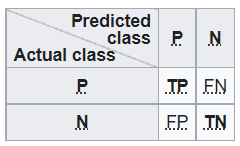

In [53]:
# Changer Matrice !!!

In [54]:
#P = 0, N = 1, 1 on ne donne pas,  0 on donne !!!

Nous pouvons également mesurer la mesure F (Fbeta_score), la mesure Fbeta est la moyenne harmonique pondérée entre précision et rappel:

    F0.5-Measure (beta=0.5): More weight on precision, less weight on recall.
    F1-Measure (beta=1.0): Balance the weight on precision and recall.
    F2-Measure (beta=2.0): Less weight on precision, more weight on recall

En plus de la fonction Fbeta_score de Sklearn, nous allons utiliser les formules existantes, la plus courante est la formule 1 mais la 2 existe aussi.

Première formule:

    fb = (1 + beta_squared) x precision x recall / (beta_squared x precision + recall + epsilon)

Deuxième formule:

    Fb = 1/(beta x (1/precision)+(1-beta) x (1/recall))

In [55]:
def mesureF1(beta, precision, recall, epsilon):
    beta_squared = beta**2   
    formule1 = (1 + beta_squared)*(precision*recall / (beta_squared*precision + recall + epsilon))        
    formule2 = 1/(beta*(1/precision)+(1-beta)*(1/recall))
    return formule1, formule2

In [234]:
def informationModele(X_test, y_test, modeleEntraine, nomModele = 'defaut'):
    testScore = modeleEntraine.score(X_test, y_test)
    print('Test Score: ', testScore)
    
    y_pred = modeleEntraine.predict(X_test)
    joblib.dump(y_pred, r'C:\Users\Alexis\y_pred_'+ nomModele + '.joblib')
    print('y_pred: ', y_pred)
    
    print("Confusion Matrix of CV data:")
    #conf_mat = confusion_matrix(y_test, y_pred)
    #tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    conf_mat = [[tp, fn],
                [fp, tn]]
    print(conf_mat)
    conf_mat = pd.DataFrame(conf_mat, columns = ['0','1'], index = ['0','1'])
    plt.figure(figsize = (7,6))
    plt.title('Confusion Matrix Heatmap')
    sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
    plt.show()
    
    print("MSE : ", mean_squared_error(y_test, y_pred))
    print("RMSE : ", math.sqrt(mean_squared_error(y_test, y_pred)))
    
    y_predProba = modeleEntraine.predict_proba(X_test)[::,1]
    joblib.dump(y_predProba, r'C:\Users\Alexis\y_predProba_'+ nomModele + '.joblib')

    auc_xg = roc_auc_score(y_test, y_predProba)
    fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_predProba)
    plt.figure(figsize=(12, 7))
    plt.plot(fpr_xg, tpr_xg, label=f'AUC (xgboost) = {auc_xg:.2f}')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend();
    
    print("Score de Rappel:", recall_score(y_test, y_pred))
    print("Score de Precision:", precision_score(y_test, y_pred))    
    
    print("\nFBeta_Score:")
    mesureF = fbeta_score(y_test, y_pred, beta = 1)
    mesureF05 = fbeta_score(y_test, y_pred, beta = 0.5)
    mesureF2 = fbeta_score(y_test, y_pred, beta = 2)
    print("Mesure F:", mesureF)
    print("Mesure F05:", mesureF05)
    print("Mesure F2:", mesureF2)

In [57]:
#informationModele(X_test, y_test, clf, 'clf')

In [58]:
#precision_recall_fscore_support(y_test, y_pred)

### XGBoost

In [59]:
xgb = XGBClassifier(random_state = SEED)

In [60]:
xgb.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Test Score:  0.9196015305735314
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84310, 564], [6853, 526]]


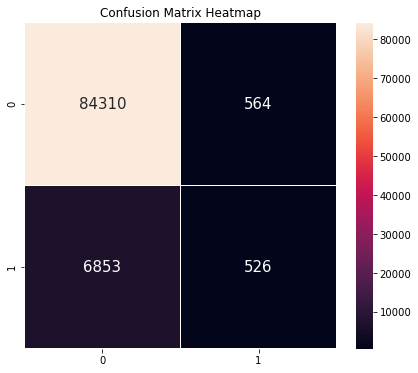

MSE :  0.08039846942646851
RMSE :  0.2835462386039859
Score de Rappel: 0.0712833717305868
Score de Precision: 0.48256880733944957

FBeta_Score:
Mesure F: 0.12421773526980753
Mesure F05: 0.2240395263651077
Mesure F2: 0.08593086322943212


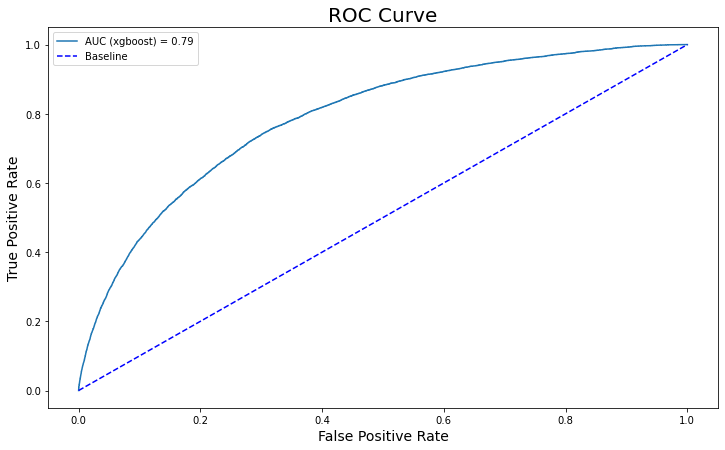

In [235]:
informationModele(X_test, y_test, xgb, 'xgb')

### LightGBM

In [69]:
lgbm = LGBMClassifier(random_state = SEED)

In [70]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [71]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

Test Score:  0.9209023012801751
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84624, 250], [7047, 332]]


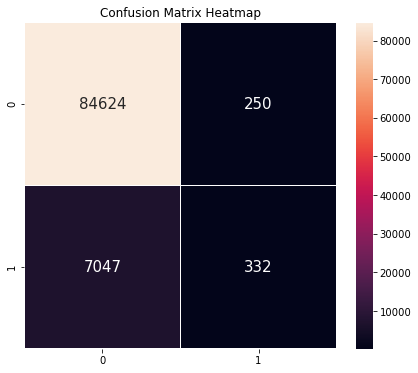

MSE :  0.07909769871982483
RMSE :  0.28124313097358455
Score de Rappel: 0.04499254641550345
Score de Precision: 0.570446735395189

FBeta_Score:
Mesure F: 0.08340660721014947
Mesure F05: 0.17101061089935093
Mesure F2: 0.05515316632334372


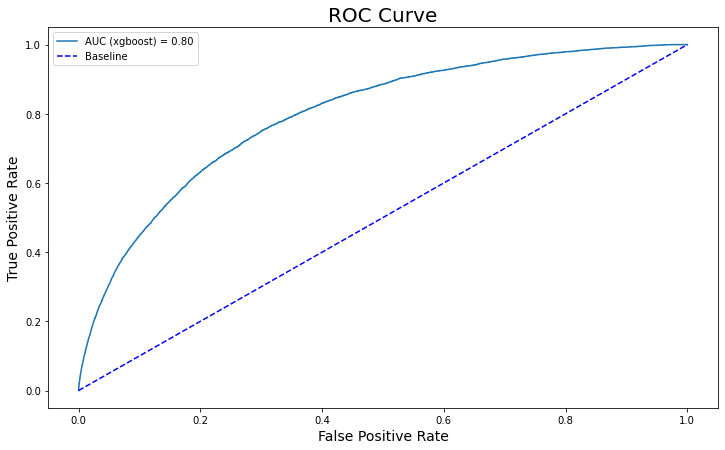

In [72]:
informationModele(X_test, y_test, lgbm, 'lgbm')

Nous allons donc essayer d'améliorer ces résultats.

## Optimisation avec GridSearchCV

### Random Forest

Pour une question de temps nous rechercherons les meilleurs hyperparamètres une fois avec 5000 lignes et ensuite nous entraînerons le dataset entier avec ces hyperparamètres, ce ne sera pas optimal malheureusement.

In [73]:
X_train5000 = X_train[0:5000]

In [74]:
y_train5000 = y_train[0:5000]

In [75]:
#param_rfr = {'n_estimators' : [500, 800, 1200, 1500],
#             'max_depth' : [15, 20, 25, 30, None],            
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [5, 10, 15, 20, 25],
#             'min_samples_split': [5, 10, 15, 20, 25]}
#
#gs_randomForestClassifier = GridSearchCV(RandomForestClassifier(),
#                 param_grid = param_rfr,            
#                  verbose = 2,
#                  cv = cv_train,
#                  scoring='roc_auc', 
#                  refit='roc_auc',
#                  return_train_score = True,                  
#                  n_jobs = -1
#                 )
#
#
#gs_randomForestClassifier.fit(X_train5000, y_train5000)

In [76]:
# print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_randomForestClassifier.best_params_)
# {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 25, 'min_samples_split': 20, 'n_estimators': 1200}

In [77]:
#rfc = RandomForestClassifier(max_depth = 25, max_features = 'auto', n_estimators = 1200, min_samples_leaf = 25, min_samples_split = 20, random_state = SEED)

In [78]:
#rfc.fit(X_train, y_train)

In [79]:
#informationModele(X_test, y_test, rfc, 'rfc')

### XGBoost

In [80]:
#param_xgb = {'max_depth' : [5, 10],
#              'min_child_weight' : [75, 80],
#              'gamma' : [0.5, 1],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'colsample_bylevel' : [0.5, 1],
#              'colsample_bynode' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#gs_XGBClassifier = GridSearchCV(XGBClassifier(),
#                 param_grid = param_xgb,            
#                  verbose = 2,
#                  cv = cv_train,
#                  scoring='roc_auc', 
#                  refit='roc_auc',
#                  return_train_score = True,                  
#                  n_jobs = -1
#                 )
#
#gs_XGBClassifier.fit(X_train5000, y_train5000)

In [81]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_XGBClassifier.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 5,
#  'min_child_weight': 75, 
#  'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 1}

In [82]:
xgbGrid = XGBClassifier(colsample_bytree = 0.5, colsample_bynode = 0.5, colsample_bylevel = 0.5, gamma = 0.5, max_depth = 5, min_child_weight = 75, reg_alpha = 0.3, reg_lambda = 0.3, subsample = 1, random_state = SEED)

In [83]:
xgbGrid.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=0.5, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=75, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0.3, reg_lambda=0.3, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Test Score:  0.9209131410360639
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84501, 373], [6923, 456]]


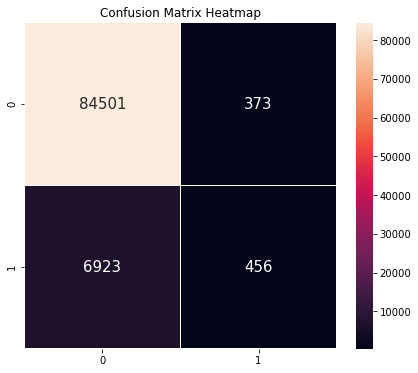

MSE :  0.07908685896393614
RMSE :  0.2812238591654985
Score de Rappel: 0.061796991462257755
Score de Precision: 0.5500603136308806

FBeta_Score:
Mesure F: 0.1111111111111111
Mesure F05: 0.2131837307152875
Mesure F2: 0.07513593672763223


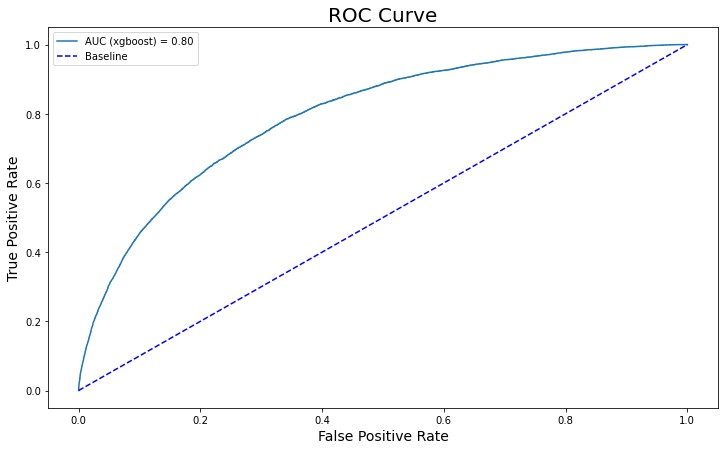

In [84]:
informationModele(X_test, y_test, xgbGrid, 'xgbGrid')

Nous pouvons voir une légère amélioration du score AUC après avoir entraîné le modèle et opter pour les meilleurs Hyperparamètre, mais regardons si nous pouvons encore l'améliorer un peu.

### LightGBM

In [85]:
#param_lgbm = {'num_leaves' : [35, 40, 45],
#              'max_depth' : [5, 10],
#              'min_split_gain' : [0, 0.1],
#              'min_child_weight' : [30, 35],
#              'min_child_samples' : [30, 35],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#gs_LGBMClassifier = GridSearchCV(LGBMClassifier(),
#                  param_grid = param_lgbm,            
#                  verbose = 2,
#                  cv = cv_train,
#                  scoring='roc_auc', 
#                  refit='roc_auc',
#                  return_train_score = True,                  
#                  n_jobs = -1
#                 )
#
#gs_LGBMClassifier.fit(X_train5000, y_train5000)

In [86]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_LGBMClassifier.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_samples': 35, 'min_child_weight': 35, 'min_split_gain': 0, 
#  'num_leaves': 35, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'subsample': 0.5}

In [87]:
lgbmGrid = LGBMClassifier(colsample_bytree = 0.5, max_depth = 5, min_child_samples = 35, min_child_weight = 35, min_split_gain = 0, num_leaves = 35, reg_alpha = 0.1, reg_lambda = 0.3, subsample = 0.5, random_state = SEED)

In [88]:
lgbmGrid.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5, max_depth=5, min_child_samples=35,
               min_child_weight=35, min_split_gain=0, num_leaves=35,
               reg_alpha=0.1, reg_lambda=0.3, subsample=0.5)

Test Score:  0.9209348205478413
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84689, 185], [7109, 270]]


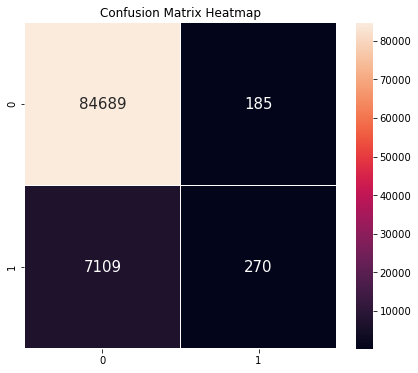

MSE :  0.07906517945215874
RMSE :  0.28118531158678745
Score de Rappel: 0.036590323892126304
Score de Precision: 0.5934065934065934

FBeta_Score:
Mesure F: 0.06893030380393157
Mesure F05: 0.1467550820741385
Mesure F2: 0.045043542090687665


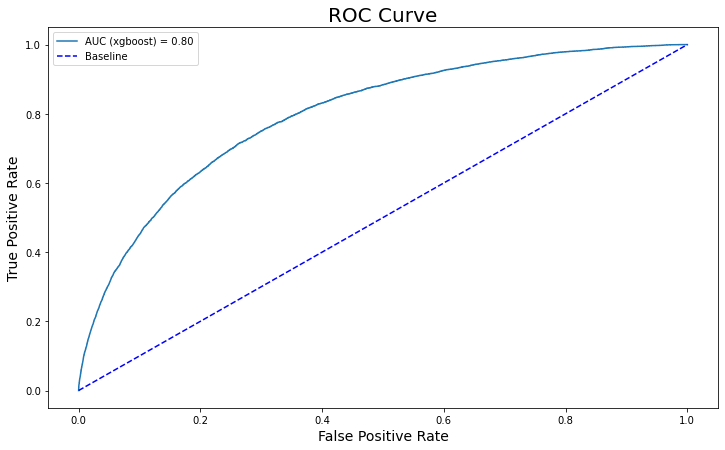

In [89]:
informationModele(X_test, y_test, lgbmGrid, 'lgbmGrid')

## Utilisation de SMOTE

Pour la suite nous allons regarder ce que nous obtenons en utilisant SMOTE (Synthetic Minority Over-Sampling TEchnique) qui est une technique utilisée pour traiter des ensembles de données déséquilibrées.

In [90]:
#!pip install imblearn

In [91]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler

In [92]:
smote = SMOTE(random_state = SEED)

X_train5000SMOTE, y_train5000SMOTE = smote.fit_resample(X_train5000, y_train5000)
X_trainSMOTE, y_trainSMOTE = smote.fit_resample(X_train, y_train)

In [93]:
from collections import Counter
counter = Counter(y_train)
print(counter)
counterSMOTE = Counter(y_trainSMOTE)
print(counterSMOTE)

Counter({0: 197808, 1: 17446})
Counter({0: 197808, 1: 197808})


### Random Forest

In [94]:
#param_rfrSMOTE1 = {'n_estimators' : [800, 1200, 1500],
#             'max_depth' : [15, 20, 25],            
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [20, 25, 30],
#             'min_samples_split': [15, 20, 25]}
#
#grid_searchRFRSMOTE1 = GridSearchCV(estimator = RandomForestClassifier(),
#                           param_grid = param_rfrSMOTE1,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchRFRSMOTE1.fit(X_train5000SMOTE, y_train5000SMOTE)

In [95]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchRFRSMOTE1.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelRandomForestSMOTE1__max_depth': 25, 'modelRandomForestSMOTE1__max_features': 'log2', 'modelRandomForestSMOTE1__min_samples_leaf': 20, 'modelRandomForestSMOTE1__min_samples_split': 25, 'modelRandomForestSMOTE1__n_estimators': 1200

In [96]:
#grid_searchRFRSMOTE1 = RandomForestClassifier(max_depth = 25, max_features = 'log2', min_samples_leaf = 20, min_samples_split = 25, n_estimators = 1200)

In [97]:
#grid_searchRFRSMOTE1 = grid_searchRFRSMOTE1.fit(X_trainSMOTE, y_trainSMOTE)

In [98]:
#informationModele(X_test, y_test, grid_searchRFRSMOTE1, 'grid_searchRFRSMOTE1')

### XGBoost

In [99]:
#param_xgbSMOTE1 = {'max_depth' : [5, 10],
#              'min_child_weight' : [75, 80],
#              'gamma' : [0.5, 1],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'colsample_bylevel' : [0.5, 1],
#              'colsample_bynode' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchXGBSMOTE1 = GridSearchCV(estimator = XGBClassifier(),
#                           param_grid = param_xgbSMOTE1,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchXGBSMOTE1.fit(X_train5000SMOTE, y_train5000SMOTE)

In [100]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchXGBSMOTE1.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelXGBSMOTE1__colsample_bylevel': 1, 'modelXGBSMOTE1__colsample_bynode': 0.5, 'modelXGBSMOTE1__colsample_bytree': 0.5, 'modelXGBSMOTE1__gamma': 1, 'modelXGBSMOTE1__max_depth': 10, 'modelXGBSMOTE1__min_child_weight': 80, 'modelXGBSMOTE1__reg_alpha': 0.3, 'modelXGBSMOTE1__reg_lambda': 0.3, 'modelXGBSMOTE1__subsample': 1

In [101]:
grid_searchXGBSMOTE1 = XGBClassifier(colsample_bylevel = 0.5, colsample_bynode = 1, colsample_bytree = 0.5, gamma = 0.5, max_depth = 5, min_child_weight = 75, reg_alpha = 0.3, reg_lambda = 0.3, subsample = 1, random_state = SEED)

In [102]:
grid_searchXGBSMOTE1 = grid_searchXGBSMOTE1.fit(X_trainSMOTE, y_trainSMOTE)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Test Score:  0.9200568003208568
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84368, 506], [6869, 510]]


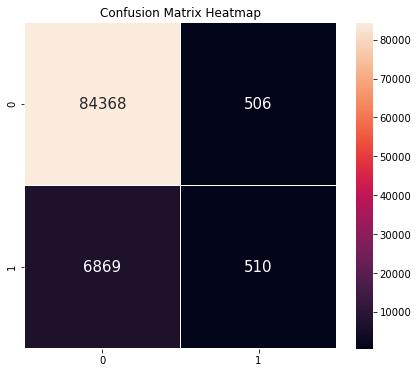

MSE :  0.07994319967914322
RMSE :  0.28274228491533276
Score de Rappel: 0.06911505624068302
Score de Precision: 0.5019685039370079

FBeta_Score:
Mesure F: 0.12150089338892199
Mesure F05: 0.22284365987940224
Mesure F2: 0.08351893095768376


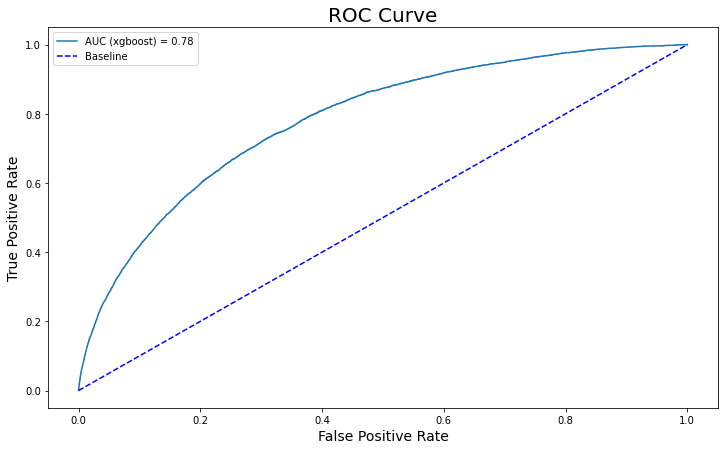

In [103]:
informationModele(X_test, y_test, grid_searchXGBSMOTE1, 'grid_searchXGBSMOTE1')

### LightGBM

In [104]:
#param_lgbmSMOTE1 = {'num_leaves' : [35, 40, 45],
#              'max_depth' : [5, 10],
#              'min_split_gain' : [0, 0.1],
#              'min_child_weight' : [30, 35],
#              'min_child_samples' : [30, 35],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchLGBMSMOTE1 = GridSearchCV(estimator = LGBMClassifier(),
#                           param_grid = param_lgbmSMOTE1,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchLGBMSMOTE1.fit(X_train5000SMOTE, y_train5000SMOTE)

In [105]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchLGBMSMOTE1.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelLGBMSMOTE1__colsample_bytree': 0.5, 'modelLGBMSMOTE1__max_depth': 10, 'modelLGBMSMOTE1__min_child_samples': 35, 'modelLGBMSMOTE1__min_child_weight': 30, 'modelLGBMSMOTE1__min_split_gain': 0, 'modelLGBMSMOTE1__num_leaves': 35, 'modelLGBMSMOTE1__reg_alpha': 0.3, 'modelLGBMSMOTE1__reg_lambda': 0.1, 'modelLGBMSMOTE1__subsample': 0.5

In [106]:
grid_searchLGBMSMOTE1 = LGBMClassifier(colsample_bytree = 0.5, max_depth = 5, min_child_samples = 30, min_child_weight = 30, min_split_gain = 0, num_leaves = 35, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.5, random_state = SEED)

In [107]:
grid_searchLGBMSMOTE1 = grid_searchLGBMSMOTE1.fit(X_trainSMOTE, y_trainSMOTE)

Test Score:  0.9197099281324185
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84646, 228], [7179, 200]]


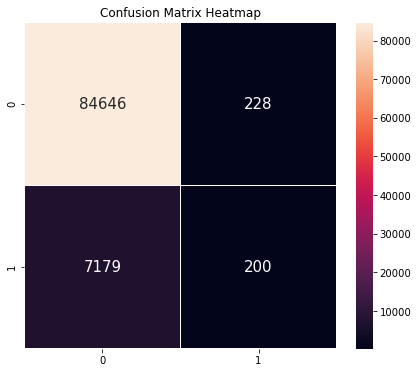

MSE :  0.08029007186758154
RMSE :  0.2833550279553577
Score de Rappel: 0.027103943623797262
Score de Precision: 0.4672897196261682

FBeta_Score:
Mesure F: 0.05123607019341617
Mesure F05: 0.10999890001099989
Mesure F2: 0.03339567192091905


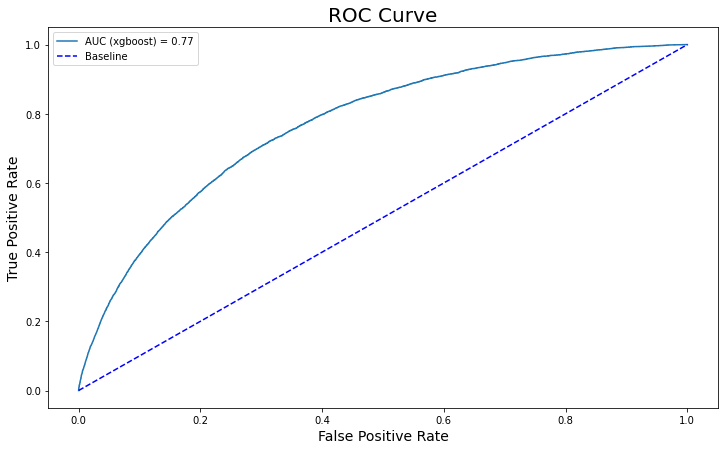

In [108]:
informationModele(X_test, y_test, grid_searchLGBMSMOTE1, 'grid_searchLGBMSMOTE1')

## Utilisation de SMOTE combiné avec un sous-échantillonnage de la classe majoritaire

In [109]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbpipeline(steps=steps)

X_trainSMOTE5000U, y_trainSMOTE5000U = pipeline.fit_resample(X_train5000, y_train5000)
X_trainSMOTEU, y_trainSMOTEU = pipeline.fit_resample(X_train, y_train)

In [110]:
from collections import Counter
counter = Counter(y_train)
print(counter)
counterSMOTE = Counter(y_trainSMOTEU)
print(counterSMOTE)

Counter({0: 197808, 1: 17446})
Counter({0: 39560, 1: 19780})


In [111]:
stratified_kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = SEED)

### Random Forest

In [112]:
#param_rfr = {'n_estimators' : [800, 1200, 1500],
#             'max_depth' : [15, 20, 25],            
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [20, 25, 30],
#             'min_samples_split': [15, 20, 25]}
#
#grid_searchRFR = GridSearchCV(estimator = RandomForestClassifier(),
#                           param_grid = param_rfr,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchRFR.fit(X_trainSMOTE5000U, y_trainSMOTE5000U)

In [113]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchRFR.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelRandomForest__max_depth': 20, 'modelRandomForest__max_features': 'auto', 'modelRandomForest__min_samples_leaf': 20, 'modelRandomForest__min_samples_split': 25, 'modelRandomForest__n_estimators': 1200

In [114]:
#grid_searchRFR = RandomForestClassifier(max_depth = 20, max_features = 'auto', min_samples_leaf = 20, min_samples_split = 25, n_estimators = 1200)

In [115]:
#grid_searchRFR = grid_searchRFR.fit(X_trainSMOTEU, y_trainSMOTEU)

In [116]:
#informationModele(X_test, y_test, grid_searchRFR, 'grid_searchRFR')

### XGBoost

In [117]:
#param_xgb = {'max_depth' : [5, 10],
#              'min_child_weight' : [75, 80],
#              'gamma' : [0.5, 1],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'colsample_bylevel' : [0.5, 1],
#              'colsample_bynode' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchXGB = GridSearchCV(estimator = XGBClassifier(),
#                           param_grid = param_xgb,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchXGB.fit(X_trainSMOTE5000U, y_trainSMOTE5000U)

In [118]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchXGB.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 80, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 1

In [119]:
grid_searchXGB = XGBClassifier(colsample_bylevel = 0.5, colsample_bynode = 0.5, colsample_bytree = 0.5, gamma = 0.5, max_depth = 5, min_child_weight = 80, reg_alpha = 0.3, reg_lambda = 0.3, subsample = 1, random_state = SEED)

In [120]:
grid_searchXGB = grid_searchXGB.fit(X_trainSMOTEU, y_trainSMOTEU)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:31:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Test Score:  0.8469209673398155
y_pred:  [0 0 0 ... 0 1 1]
Confusion Matrix of CV data:
[[74618, 10256], [3866, 3513]]


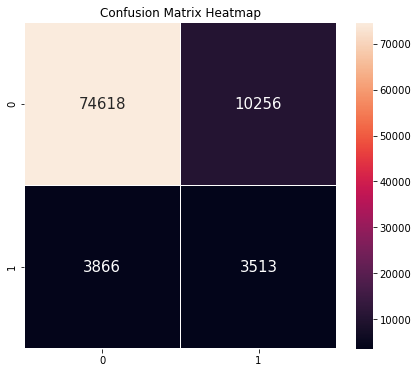

MSE :  0.1530790326601845
RMSE :  0.3912531567414945
Score de Rappel: 0.4760807697519989
Score de Precision: 0.255138354274094

FBeta_Score:
Mesure F: 0.3322299981085682
Mesure F05: 0.2812424945961092
Mesure F2: 0.40579877555735244


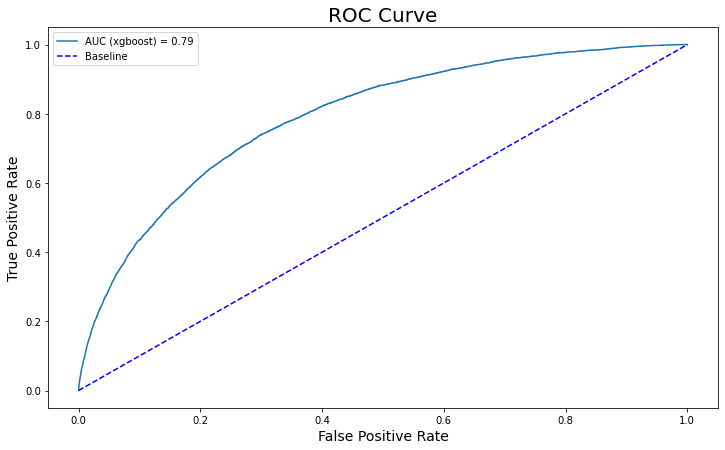

In [121]:
informationModele(X_test, y_test, grid_searchXGB, 'grid_searchXGB')

### LightGBM

In [122]:
#param_lgbm = {'num_leaves' : [35, 40, 45],
#              'max_depth' : [5, 10],
#              'min_split_gain' : [0, 0.1],
#              'min_child_weight' : [30, 35],
#              'min_child_samples' : [30, 35],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchLGBM = GridSearchCV(estimator = LGBMClassifier(),
#                           param_grid = param_lgbm,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchLGBM.fit(X_trainSMOTE5000U, y_trainSMOTE5000U)

In [123]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchLGBM.best_params_)
#SMOTEU
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_samples': 30, 'min_child_weight': 30, 'min_split_gain': 0, 'num_leaves': 35, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5

In [124]:
grid_searchLGBM = LGBMClassifier(colsample_bytree = 0.5, max_depth = 5, min_child_samples = 30, min_child_weight = 30, min_split_gain = 0, num_leaves = 35, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.5, random_state = SEED)

In [125]:
grid_searchLGBM = grid_searchLGBM.fit(X_trainSMOTEU, y_trainSMOTEU)

Test Score:  0.8555168937595525
y_pred:  [0 0 0 ... 0 1 1]
Confusion Matrix of CV data:
[[75453, 9421], [3908, 3471]]


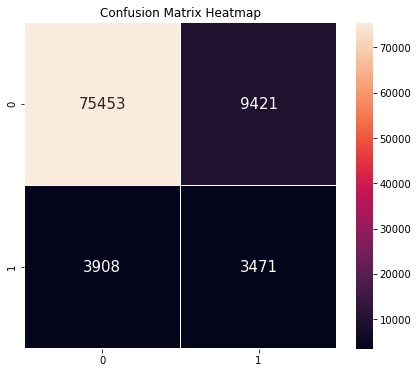

MSE :  0.14448310624044747
RMSE :  0.38010933458736246
Score de Rappel: 0.4703889415910015
Score de Precision: 0.26923673596028547

FBeta_Score:
Mesure F: 0.34245967145182776
Mesure F05: 0.2944170186777953
Mesure F2: 0.4092388228636107


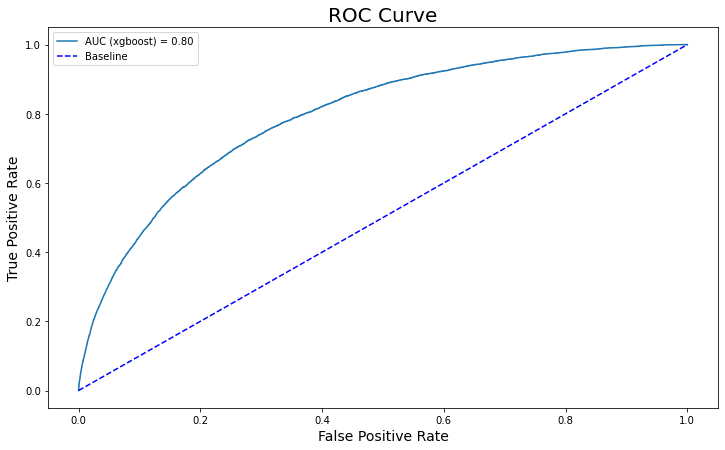

In [126]:
informationModele(X_test, y_test, grid_searchLGBM, 'grid_searchLGBM')

Nous allons maintenant regarder ce que nous obtenons avec HyperOpt.

Mais avant ça faisons une récapitulation rapide des différents résultats:

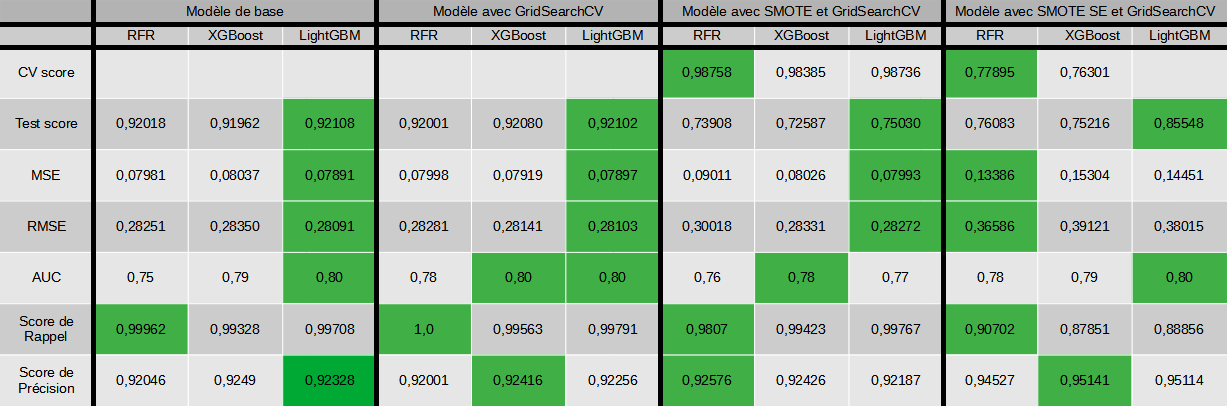

Nous pouvons que dans l'ensemble LightGBM est meilleur, nous pouvons également voir que nous avons de meilleurs résultats sans l'utilisation de SMOTE, que ce soit SMOTE seulement ou en combinant SMOTE avec un sous échantillonage.

Pour la suite nous utiliserons LightGBM, non seulement pour les résultats comme on a pu voir mais également le temps de calcul qui est bien meilleur que les autres.

Regardons maintenant une récapitulation rapide du FScore des différents modèles:

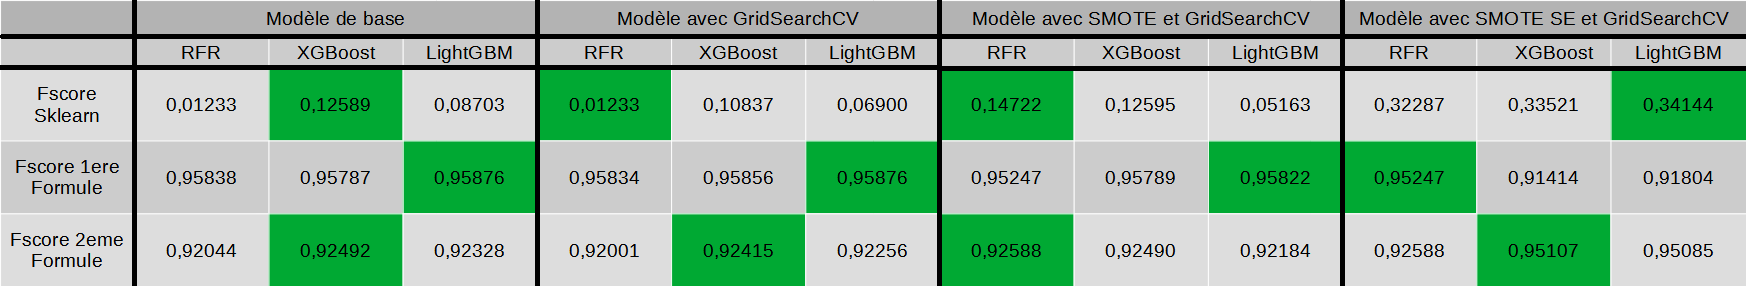

In [127]:
# Refaire matrice !!!

Comme précèdemment nous pouvons voir que LightGBM a de bons résultats notamment pour la 1ere formule, mais nous pouvons également voir que les résultats sont tout de même assez proche, mais pour une question de temps nous opterons pour LightGBM pour la suite.

## HyperOpt

In [128]:
from hyperopt import hp, tpe, fmin, Trials
from sklearn.model_selection import cross_val_score

In [129]:
space_lgbmHP = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),         
                'max_depth' : hp.quniform('max_depth', 2, 30, 1),
                'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
                'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
                'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 1),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
                'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
                'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
                'solvability_threshold' : hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)              
               }

### Metric ROC_AUC

In [130]:
def objectiveROC_AUC(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHP = LGBMClassifier(**params)
    score = cross_val_score(lgbmHP, X_train, y_train, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [131]:
#bestROC_AUC = fmin(fn = objectiveROC_AUC, space = space_lgbmHP, algo = tpe.suggest, max_evals=20, trials = Trials(), rstate = SEED )

In [132]:
#bestROC_AUC

In [133]:
#'colsample_bytree': 0.2,
# 'max_depth': 5.0,
# 'min_child_samples': 64.0,
# 'min_child_weight': 5.0,
# 'min_split_gain': 0.075,
# 'num_leaves': 28.0,
# 'reg_alpha': 0.30000000000000004,
# 'reg_lambda': 0.4,
# 'solvability_threshold': 0.05,
# 'subsample': 0.75

In [134]:
lgbmHP = LGBMClassifier(num_leaves = 28, max_depth = 5, min_split_gain = 0.075, min_child_weight = 5, min_child_samples = 64, subsample = 0.75, colsample_bytree = 0.2, reg_alpha = 0.3, reg_lambda = 0.4, random_state=SEED)
lgbmHP.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.2, max_depth=5, min_child_samples=64,
               min_child_weight=5, min_split_gain=0.075, num_leaves=28,
               reg_alpha=0.3, reg_lambda=0.4, subsample=0.75)

Test Score:  0.92119497468917
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84718, 156], [7114, 265]]


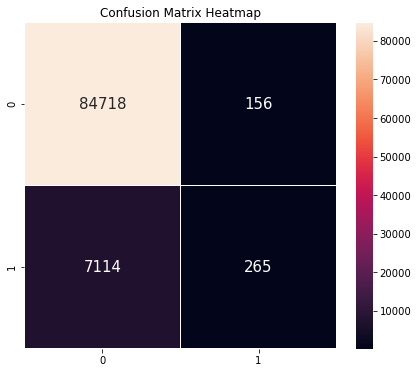

MSE :  0.07880502531083
RMSE :  0.2807223277739589
Score de Rappel: 0.035912725301531376
Score de Precision: 0.6294536817102138

FBeta_Score:
Mesure F: 0.06794871794871796
Mesure F05: 0.14619883040935674
Mesure F2: 0.044259611851554935


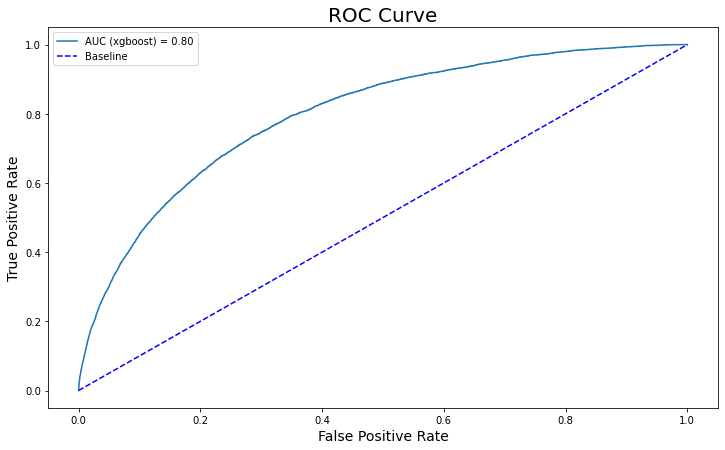

In [135]:
informationModele(X_test, y_test, lgbmHP, 'lgbmHP')

### Metric F1

In [136]:
def objectiveF1Score(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPF1 = LGBMClassifier(**params)
    score = cross_val_score(lgbmHPF1, X_train, y_train, scoring = 'f1', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [137]:
#bestF1 = fmin(fn = objectiveROC_AUC, space = space_lgbmHP, algo = tpe.suggest, max_evals=20, trials = Trials(), rstate = SEED )

In [138]:
#bestF1

In [139]:
#'colsample_bytree': 0.2,
# 'max_depth': 5.0,
# 'min_child_samples': 64.0,
# 'min_child_weight': 5.0,
# 'min_split_gain': 0.075,
# 'num_leaves': 28.0,
# 'reg_alpha': 0.30000000000000004,
# 'reg_lambda': 0.4,
# 'solvability_threshold': 0.05,
# 'subsample': 0.75

In [140]:
lgbmHPF1 = LGBMClassifier(num_leaves = 28, max_depth = 5, min_split_gain =  0.075, min_child_weight = 5, min_child_samples = 64, subsample = 0.75, colsample_bytree = 0.2, reg_alpha = 0.3, reg_lambda = 0.4, random_state=SEED)
lgbmHPF1.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.2, max_depth=5, min_child_samples=64,
               min_child_weight=5, min_split_gain=0.075, num_leaves=28,
               reg_alpha=0.3, reg_lambda=0.4, subsample=0.75)

Test Score:  0.92119497468917
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84718, 156], [7114, 265]]


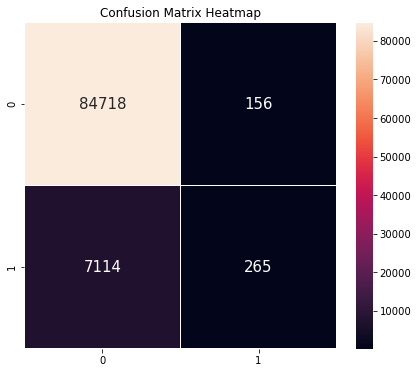

MSE :  0.07880502531083
RMSE :  0.2807223277739589
Score de Rappel: 0.035912725301531376
Score de Precision: 0.6294536817102138

FBeta_Score:
Mesure F: 0.06794871794871796
Mesure F05: 0.14619883040935674
Mesure F2: 0.044259611851554935


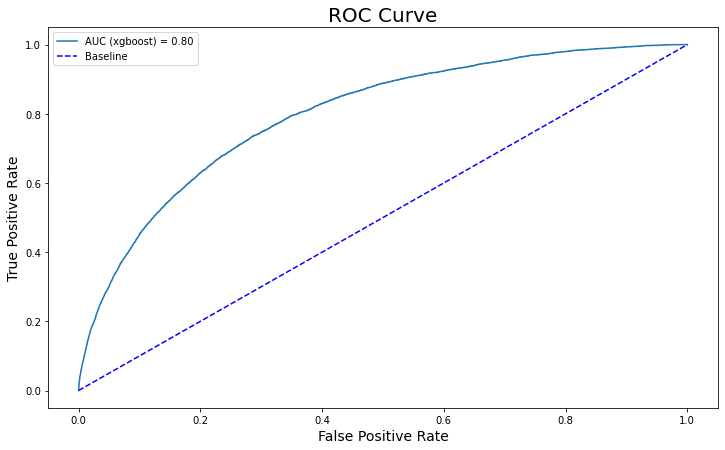

In [141]:
informationModele(X_test, y_test, lgbmHPF1, 'lgbmHPF1')

### Metric ROC_AUC avec SMOTE SE

In [142]:
def objectiveROC_AUCSMOTEU(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPSMOTEU = LGBMClassifier(**params)
    score = cross_val_score(lgbmHPSMOTEU, X_trainSMOTEU, y_trainSMOTEU, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [143]:
#bestROC_AUCSMOTEU = fmin(fn = objectiveROC_AUCSMOTEU, space = space_lgbmHP, algo = tpe.suggest, max_evals=20, trials = Trials(), rstate = SEED )

In [144]:
#bestROC_AUCSMOTEU

In [145]:
#'colsample_bytree': 0.30000000000000004,
# 'max_depth': 2.0,
# 'min_child_samples': 59.0,
# 'min_child_weight': 13.0,
# 'min_split_gain': 0.03,
# 'num_leaves': 37.0,
# 'reg_alpha': 0.6000000000000001,
# 'reg_lambda': 1.4000000000000001,
# 'solvability_threshold': 0.17500000000000002,
# 'subsample': 0.7000000000000001

In [146]:
lgbmHPSMOTE_SE = LGBMClassifier(num_leaves = 37, max_depth = 2, min_split_gain =  0.03, min_child_weight = 13, min_child_samples = 59, subsample = 0.7, colsample_bytree = 0.3, reg_alpha = 0.6, reg_lambda = 1.4, random_state=SEED)
lgbmHPSMOTE_SE.fit(X_trainSMOTEU, y_trainSMOTEU)

LGBMClassifier(colsample_bytree=0.3, max_depth=2, min_child_samples=59,
               min_child_weight=13, min_split_gain=0.03, num_leaves=37,
               reg_alpha=0.6, reg_lambda=1.4, subsample=0.7)

Test Score:  0.8512135106717397
y_pred:  [0 0 0 ... 0 1 1]
Confusion Matrix of CV data:
[[75181, 9693], [4033, 3346]]


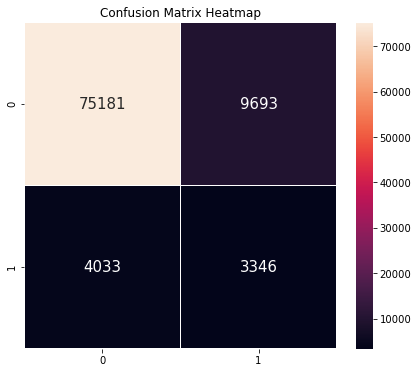

MSE :  0.14878648932826033
RMSE :  0.3857285176497329
Score de Rappel: 0.4534489768261282
Score de Precision: 0.2566147710714012

FBeta_Score:
Mesure F: 0.32775002448819673
Mesure F05: 0.2810111699000588
Mesure F2: 0.39313829162260605


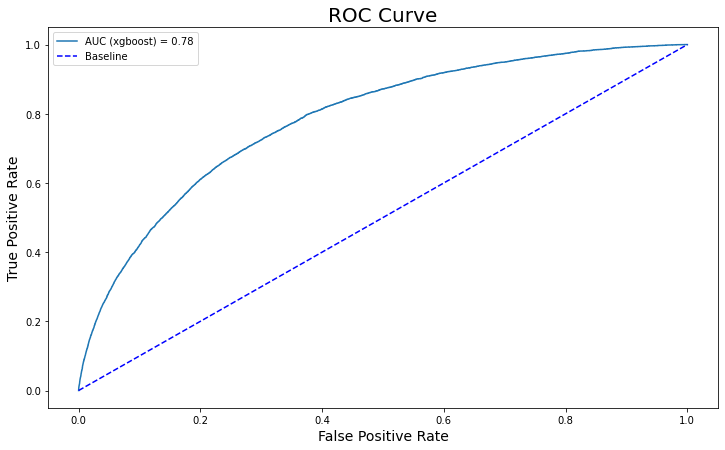

In [147]:
informationModele(X_test, y_test, lgbmHPSMOTE_SE, 'lgbmHPSMOTE_SE')

Nous pouvons voir que le score AUC est legérement moins bon qu'avec la recherche GridSearchCv, mais pour le coût métier nous regarderons tout de même ce que l'on aura.

Nous savons qu'un faux négatif coûte 10x plus cher qu'un faux positif, c'est pour ça que nous devons essayer d'avoir le moins de faux négatif possible, nous allons donc définir une nouvelle métrique.

In [148]:
#np.where(blended_cv_preds >= best_threshold, 1, 0))

In [149]:
def coutMetier(y_test, y_pred, fn_value = 10, fp_value = 1):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()    
    scoreMetier = fn*fn_value + fp*fp_value
    return scoreMetier

Maintenant regardons ce que nous avons en modifiant le seuil des meilleurs modèles (score roc_auc = 80 càd XGBoost et LGBM avec GridSearchCv et LGBM avec SMOTE et SE etGridSearchCV):

In [168]:
thresholds = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]

In [151]:
y_predXGBGRIDM = xgbGrid.predict_proba(X_test)[::,1]
y_predLGBMGRIDM = lgbmGrid.predict_proba(X_test)[::,1]

y_predXGBGRID = xgbGrid.predict(X_test)
y_predLGBMGRID = lgbmGrid.predict(X_test)

Nous allons regarder dans un premier temps le nombre de 1 et de 0 avant l'optimisation du seuil:

In [152]:
from collections import Counter
counter = Counter(y_predXGBGRID)
print(counter)

Counter({0: 91424, 1: 829})


In [153]:
from collections import Counter
counter = Counter(y_predLGBMGRID)
print(counter)

Counter({0: 91798, 1: 455})


##### Modèle XGBoost avec GridSearchCV

In [169]:
coutmetier = 1000000000
listeSeuil = []

for t in thresholds:
    predicted_class1XGBGRID = np.zeros(y_predXGBGRIDM.shape)
    predicted_class1XGBGRID[y_predXGBGRIDM > t] = 1
    coutAReduire = coutMetier(y_test, predicted_class1XGBGRID)
    if coutAReduire < coutmetier:
        listeSeuil.append(t)
        coutmetier = coutAReduire
    else:
        continue

In [170]:
listeSeuil

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.86,
 0.87,
 0.9]

In [181]:
predicted_class1XGBGRID = np.zeros(y_predXGBGRIDM.shape)
predicted_class1XGBGRID[y_predXGBGRIDM > 0.9] = 1
coutAReduire = coutMetier(y_test, predicted_class1XGBGRID)
print("Coût métier:", coutAReduire)

Coût métier: 7377


Regardons maintenant le nombre de 1 et de 0 après avoir utilisé le meilleur seuil, nous ferons de même après chaque modèle:

In [172]:
from collections import Counter
counter = Counter(predicted_class1XGBGRID)
print(counter)

Counter({0.0: 69337, 1.0: 22916})


##### Modèle LightGBM avec GridSearchCV

In [173]:
coutmetier = 1000000000
listeSeuil = []

for t in thresholds:
    predicted_class1LGBMGRID = np.zeros(y_predLGBMGRIDM.shape)
    predicted_class1LGBMGRID[y_predLGBMGRIDM > t] = 1
    coutAReduire = coutMetier(y_test, predicted_class1LGBMGRID)
    #print(t, ':', coutAReduire)
    if coutAReduire < coutmetier:
        listeSeuil.append(t)
        coutmetier = coutAReduire
    else:
        continue

In [174]:
listeSeuil

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.7,
 0.71,
 0.72,
 0.73,
 0.79]

In [175]:
predicted_class1LGBMGRID = np.zeros(y_predLGBMGRIDM.shape)
predicted_class1LGBMGRID[y_predLGBMGRIDM > 0.79] = 1
coutAReduire = coutMetier(y_test, predicted_class1LGBMGRID)
print("Coût métier:", coutAReduire)

Coût métier: 7368


In [176]:
from collections import Counter
counter = Counter(predicted_class1LGBMGRID)
print(counter)

Counter({0.0: 92242, 1.0: 11})


Regardons d'autre seuil pour le meilleur modèle, nous prendrons 0.35 et 0.8 par défaut, afin de voir ce que nous obtiendrons:

In [177]:
predicted_class1LGBMGRID35 = np.zeros(y_predLGBMGRIDM.shape)
predicted_class1LGBMGRID35[y_predLGBMGRIDM > 0.35] = 1
coutAReduire = coutMetier(y_test, predicted_class1LGBMGRID35)
print("Coût métier:", coutAReduire)

Coût métier: 17811


In [178]:
from collections import Counter
counter = Counter(predicted_class1LGBMGRID35)
print(counter)

Counter({0.0: 90134, 1.0: 2119})


In [179]:
predicted_class1LGBMGRID80 = np.zeros(y_predLGBMGRIDM.shape)
predicted_class1LGBMGRID80[y_predLGBMGRIDM > 0.80] = 1
coutAReduire = coutMetier(y_test, predicted_class1LGBMGRID80)
print("Coût métier:", coutAReduire)

Coût métier: 7369


In [180]:
from collections import Counter
counter = Counter(predicted_class1LGBMGRID80)
print(counter)

Counter({0.0: 92243, 1.0: 10})


Nous avons notre coût métier au plus faible lorsque le seuil est de 0.79 et que nous prenons le modèle LightGBM et GRidSearchCV, dans ce cas le coût métier vaut 7368.

Nous allons faire un nouvelle entraînement avec ce seuil:

### Avec le meilleur seuil trouvé

In [187]:
space_lgbmHPSeuil = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),         
                     'max_depth' : hp.quniform('max_depth', 2, 30, 1),
                     'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
                     'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 1),
                     'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                     'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
                     'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
                     'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
                     'class_weight' : hp.choice('class_weight', [None, 'balanced']),
                     'solvability_threshold' : 0.79          
                    }

In [188]:
def objectiveRocAucSeuil(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'class_weight' : params['class_weight'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPSeuil = LGBMClassifier(**params)
    score = -cross_val_score(lgbmHPSeuil, X_train, y_train, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [191]:
#bestRocAucSeuil = fmin(fn = objectiveRocAucSeuil, space = space_lgbmHPSeuil, algo = tpe.suggest, max_evals = 15, trials = Trials(), rstate = SEED )

In [192]:
#bestRocAucSeuil

In [193]:
#'class_weight': 0,
# 'colsample_bytree': 0.65,
# 'max_depth': 10.0,
# 'min_child_samples': 42.0,
# 'min_child_weight': 23.0,
# 'min_split_gain': 0.095,
# 'num_leaves': 48.0,
# 'reg_alpha': 0.8,
# 'reg_lambda': 1.2000000000000002,
# 'subsample': 0.75

In [194]:
lgbmHPSeuil = LGBMClassifier(num_leaves = 48, max_depth = 10, min_split_gain = 0.095, min_child_weight = 23, min_child_samples = 42, subsample = 0.75, colsample_bytree = 0.65, reg_alpha = 0.8, reg_lambda = 1.2, class_weight = None,  random_state=SEED)
lgbmHPSeuil.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.65, max_depth=10, min_child_samples=42,
               min_child_weight=23, min_split_gain=0.095, num_leaves=48,
               reg_alpha=0.8, reg_lambda=1.2, subsample=0.75)

Test Score:  0.9213142120039457
y_pred:  [0 0 0 ... 0 0 0]
Confusion Matrix of CV data:
[[84586, 288], [6971, 408]]


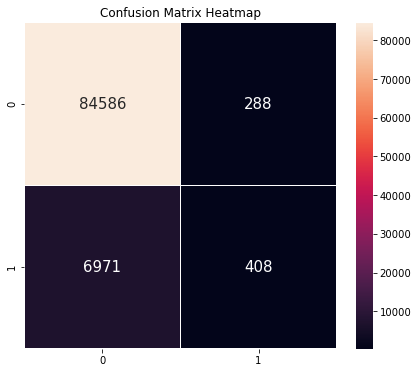

MSE :  0.07868578799605433
RMSE :  0.2805098714770201
Score de Rappel: 0.05529204499254642
Score de Precision: 0.5862068965517241

FBeta_Score:
Mesure F: 0.10105263157894738
Mesure F05: 0.20072813145724688
Mesure F2: 0.06752283860717596


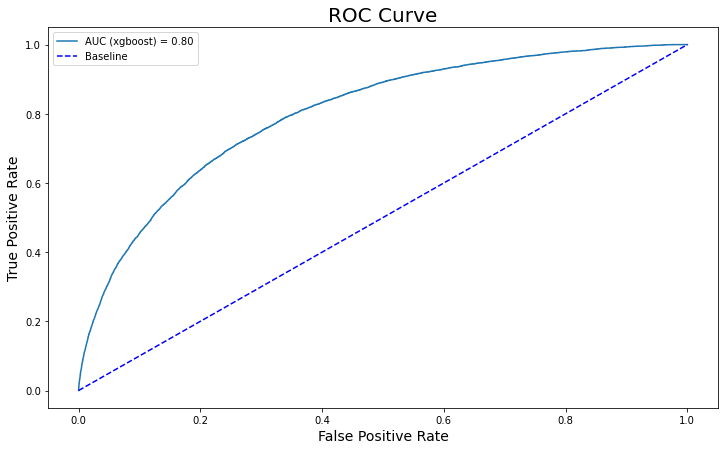

In [195]:
informationModele(X_test, y_test, lgbmHPSeuil, 'lgbmHPSeuil')

In [196]:
joblib.dump(lgbmHPSeuil, r'C:\Users\Alexis\lgbmHPSeuil.joblib')

['C:\\Users\\Alexis\\lgbmHPSeuil.joblib']

Regardons maintenant ce que nous obtenons lorsque nous prenons la liste des prédictions après avoir modifié le seuil, nous ferons une rapide fonction, semblable à ce qu'on a pu faire précèdemment mais qui va s'adapter à ce nouveau cas de figure:

In [211]:
y_predLgbmHPSeuilProba = lgbmHPSeuil.predict_proba(X_test)[::,1]
y_predLgbmHPSeuil = lgbmHPSeuil.predict(X_test)

In [212]:
def informationModeleSeuil(y_test, y_predSeuil):

    print("Confusion Matrix of CV data:")
    #conf_mat = confusion_matrix(y_test, y_predSeuil)
    tp, fn, fp, tn = confusion_matrix(y_test, y_predSeuil).ravel() 
    conf_mat = [[tp, fn],
                [fp, tn]]
    conf_mat = pd.DataFrame(conf_mat, columns = ['0','1'], index = ['0','1'])
    plt.figure(figsize = (7,6))
    plt.title('Confusion Matrix Heatmap')
    sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
    plt.show()
    
    print("MSE : ", mean_squared_error(y_test, y_predSeuil))
    print("RMSE : ", math.sqrt(mean_squared_error(y_test, y_predSeuil)))

    auc_xg = roc_auc_score(y_test, y_predSeuil)
    fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_predSeuil)
    plt.figure(figsize=(12, 7))
    plt.plot(fpr_xg, tpr_xg, label=f'AUC = {auc_xg:.2f}')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend();
    
    print("Score de Rappel:", recall_score(y_test, y_predSeuil))
    print("Score de Precision:", precision_score(y_test, y_predSeuil))    
    
    print("\nFBeta_Score:")
    mesureF = fbeta_score(y_test, y_predSeuil, beta = 1)
    mesureF05 = fbeta_score(y_test, y_predSeuil, beta = 0.5)
    mesureF2 = fbeta_score(y_test, y_predSeuil, beta = 2)
    print("Mesure F:", mesureF)
    print("Mesure F05:", mesureF05)
    print("Mesure F2:", mesureF2)

Confusion Matrix of CV data:


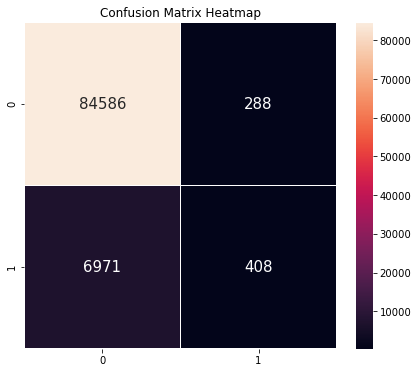

MSE :  0.07868578799605433
RMSE :  0.2805098714770201
Score de Rappel: 0.05529204499254642
Score de Precision: 0.5862068965517241

FBeta_Score:
Mesure F: 0.10105263157894738
Mesure F05: 0.20072813145724688
Mesure F2: 0.06752283860717596


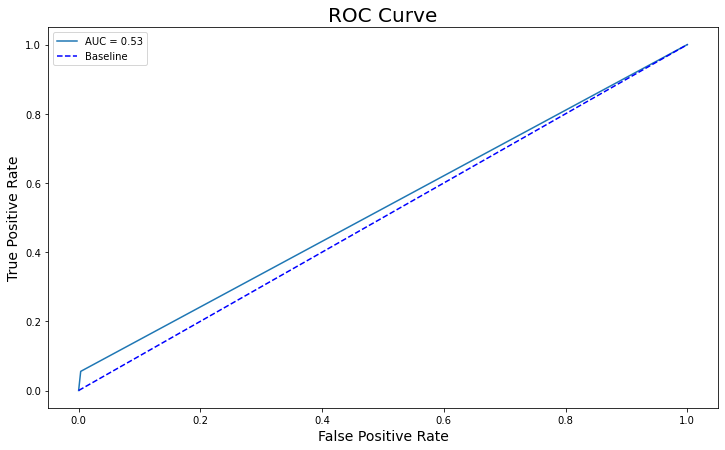

In [213]:
informationModeleSeuil(y_test, y_predLgbmHPSeuil)

In [214]:
with open('lgbmHPSeuil.pkl', 'wb') as fid:
    pickle.dump(lgbmHPSeuil, fid,2) 

### Avec un seuil aléatoire afin de comparé, ici ce sera 0.80

In [215]:
space_lgbmHPSeuil80 = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),         
                       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
                       'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
                       'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
                       'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 1),
                       'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                       'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
                       'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
                       'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
                       'class_weight' : hp.choice('class_weight', [None, 'balanced']),
                       'solvability_threshold' : 0.80            
                      }

In [216]:
def objectiveRocAucSeuil80(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'class_weight' : params['class_weight'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPSeuil80 = LGBMClassifier(**params)
    score = -cross_val_score(lgbmHPSeuil80, X_train, y_train, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [217]:
bestRocAucSeuil80 = fmin(fn = objectiveRocAucSeuil80, space = space_lgbmHPSeuil80, algo = tpe.suggest, max_evals = 15, trials = Trials(), rstate = SEED )

100%|██████████████████████████████████████████████| 15/15 [53:44<00:00, 214.97s/trial, best loss: -0.7964643301757204]


In [218]:
bestRocAucSeuil80

{'class_weight': 1,
 'colsample_bytree': 0.9500000000000001,
 'max_depth': 20.0,
 'min_child_samples': 38.0,
 'min_child_weight': 32.0,
 'min_split_gain': 0.015,
 'num_leaves': 33.0,
 'reg_alpha': 1.3,
 'reg_lambda': 1.3,
 'subsample': 0.7000000000000001}

In [ ]:
#'class_weight': 0,
# 'colsample_bytree': 0.65,
# 'max_depth': 13.0,
# 'min_child_samples': 46.0,
# 'min_child_weight': 20.0,
# 'min_split_gain': 0.05,
# 'num_leaves': 41.0,
# 'reg_alpha': 1.4000000000000001,
# 'reg_lambda': 0.30000000000000004,
# 'subsample': 0.9

In [ ]:
lgbmHPSeuil80 = LGBMClassifier(num_leaves = 41, max_depth = 13, min_split_gain = 0.05, min_child_weight = 20, min_child_samples = 46, subsample = 0.9, colsample_bytree = 0.65, reg_alpha = 1.4, reg_lambda = 0.3, class_weight = None, random_state=SEED)
lgbmHPSeuil80.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmHPSeuil80, 'lgbmHPSeuil80')

In [ ]:
informationModeleSeuil(y_test, predicted_class1LGBMGRID80)

### Avec un seuil aléatoire afin de comparé, ici ce sera 0.35

In [219]:
space_lgbmHPSeuil35 = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),         
                       'max_depth' : hp.quniform('max_depth', 2, 30, 1),
                       'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
                       'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
                       'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 1),
                       'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                       'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
                       'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
                       'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
                       'class_weight' : hp.choice('class_weight', [None, 'balanced']),
                       'solvability_threshold' : 0.35            
                       }

In [220]:
def objectiveRocAucSeuil35(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'class_weight': params['class_weight'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPSeuil35 = LGBMClassifier(**params)
    score = -cross_val_score(lgbmHPSeuil35, X_train, y_train, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [228]:
bestRocAucSeuil35 = fmin(fn = objectiveRocAucSeuil35, space = space_lgbmHPSeuil35, algo = tpe.suggest, max_evals = 15, trials = Trials(), rstate = SEED )

100%|██████████████████████████████████████████████| 15/15 [59:20<00:00, 237.34s/trial, best loss: -0.7958096736947774]


In [229]:
bestRocAucSeuil35

{'class_weight': 1,
 'colsample_bytree': 0.9,
 'max_depth': 26.0,
 'min_child_samples': 66.0,
 'min_child_weight': 22.0,
 'min_split_gain': 0.025,
 'num_leaves': 24.0,
 'reg_alpha': 0.7000000000000001,
 'reg_lambda': 0.30000000000000004,
 'subsample': 0.6000000000000001}

In [ ]:
#'class_weight': 1,
# 'colsample_bytree': 0.9,
# 'max_depth': 26.0,
# 'min_child_samples': 66.0,
# 'min_child_weight': 22.0,
# 'min_split_gain': 0.025,
# 'num_leaves': 24.0,
# 'reg_alpha': 0.7000000000000001,
# 'reg_lambda': 0.30000000000000004,
# 'subsample': 0.6000000000000001

In [ ]:
lgbmHPSeuil35 = LGBMClassifier(num_leaves = 22, max_depth = 26, min_split_gain = 0.095, min_child_weight = 34, min_child_samples = 39, subsample = 0.95, colsample_bytree = 0.8, reg_alpha = 0.6, reg_lambda = 0.2, class_weight = None, random_state=SEED)
lgbmHPSeuil35.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmHPSeuil35, 'lgbmHPSeuil35')

In [ ]:
informationModeleSeuil(y_test, predicted_class1LGBMGRID35)

Nous pouvons voir qu'en procédant de cette manière cela ne donne pas grand chose de concluant, nous allons donc essayer autre chose cette fois ci, nous allons écrire une nouvelle fonction qui testera notre meilleur seuil qui est 0.1 ainsi que d'autre seuil aléatoire afin de comparer:

In [221]:
y_predLgbmHPSeuil = lgbmHPSeuil.predict_proba(X_test)[::,1]

In [222]:
def informationModeleSeuil(y_test, seuil):

    y_predSeuil = np.zeros(y_predLgbmHPSeuil.shape)
    y_predSeuil[y_predLgbmHPSeuil > seuil] = 1
    coutAReduire = coutMetier(y_test, y_predSeuil)
    print("Coût métier:", coutAReduire)
    
    print("Confusion Matrix of CV data:")
    conf_mat = confusion_matrix(y_test, y_predSeuil)
    conf_mat = pd.DataFrame(conf_mat, columns = ['0','1'], index = ['0','1'])
    plt.figure(figsize = (7,6))
    plt.title('Confusion Matrix Heatmap')
    sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
    plt.show()
    
    print("MSE : ", mean_squared_error(y_test, y_predSeuil))
    print("RMSE : ", math.sqrt(mean_squared_error(y_test, y_predSeuil)))

    auc_xg = roc_auc_score(y_test, y_predSeuil)
    print("Score Roc: ", auc_xg)
    
    print("Score de Rappel:", recall_score(y_test, y_predSeuil))
    print("Score de Precision:", precision_score(y_test, y_predSeuil))    
    
    print("\nFBeta_Score:")
    mesureF = fbeta_score(y_test, y_predSeuil, beta = 1)
    mesureF05 = fbeta_score(y_test, y_predSeuil, beta = 0.5)
    mesureF2 = fbeta_score(y_test, y_predSeuil, beta = 2)
    print("Mesure F:", mesureF)
    print("Mesure F05:", mesureF05)
    print("Mesure F2:", mesureF2)

In [223]:
listeSeuilRandom = []
for n in range(10):
    listeSeuilRandom.append(random.randint(0,101) / 100)

In [230]:
listeSeuil = [0.79] + listeSeuilRandom

Seuil:  0.79
Coût métier: 7384
Confusion Matrix of CV data:


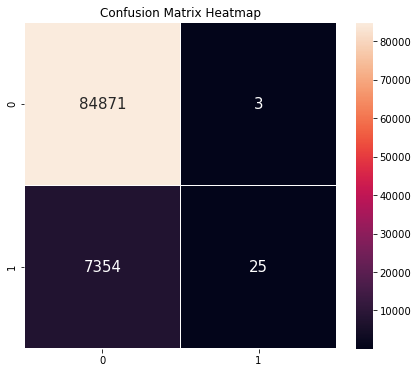

MSE :  0.07974808407314667
RMSE :  0.2823970326918232
Score Roc:  0.5016763232196596
Score de Rappel: 0.0033879929529746578
Score de Precision: 0.8928571428571429

FBeta_Score:
Mesure F: 0.006750371270419873
Mesure F05: 0.016686690695501268
Mesure F2: 0.004230977525047387
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.56
Coût métier: 8491
Confusion Matrix of CV data:


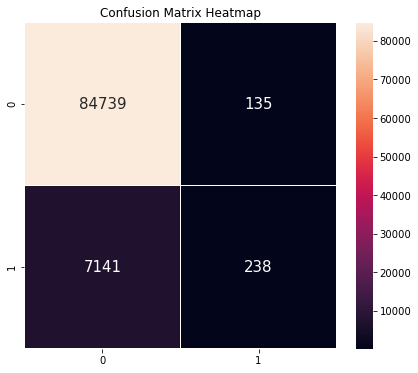

MSE :  0.07887006384616219
RMSE :  0.2808381452832969
Score Roc:  0.5153315498989098
Score de Rappel: 0.03225369291231874
Score de Precision: 0.6380697050938338

FBeta_Score:
Mesure F: 0.06140350877192982
Mesure F05: 0.13414496674557547
Mesure F2: 0.039813978386697445
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.24
Coût métier: 46522
Confusion Matrix of CV data:


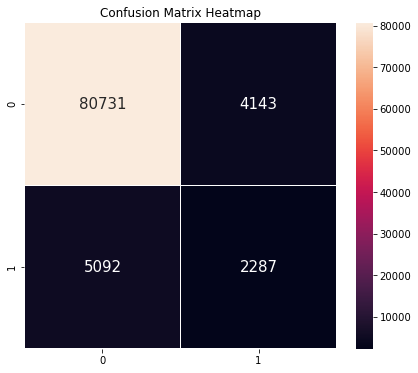

MSE :  0.10010514563212036
RMSE :  0.31639397218044524
Score Roc:  0.630560029989913
Score de Rappel: 0.3099335953381217
Score de Precision: 0.3556765163297045

FBeta_Score:
Mesure F: 0.3312332536751394
Mesure F05: 0.34547871536904434
Mesure F2: 0.3181160629833639
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.45
Coût métier: 11951
Confusion Matrix of CV data:


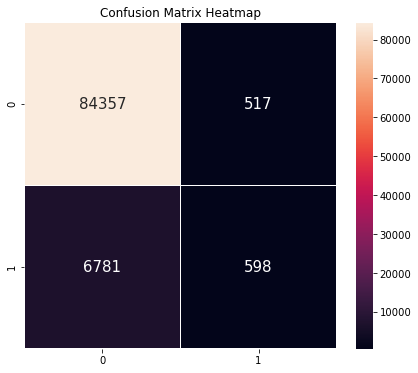

MSE :  0.07910853847571353
RMSE :  0.2812624014611863
Score Roc:  0.5374747044575916
Score de Rappel: 0.08104079143515382
Score de Precision: 0.536322869955157

FBeta_Score:
Mesure F: 0.14080527431127854
Mesure F05: 0.25255511445223416
Mesure F2: 0.09761352877803534
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.44
Coût métier: 12461
Confusion Matrix of CV data:


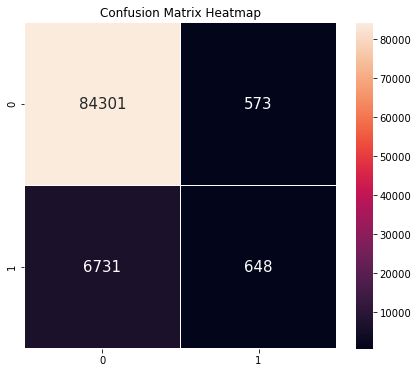

MSE :  0.07917357701104571
RMSE :  0.2813779966718182
Score Roc:  0.5405327966164479
Score de Rappel: 0.08781677734110313
Score de Precision: 0.5307125307125307

FBeta_Score:
Mesure F: 0.15069767441860463
Mesure F05: 0.2642094104215934
Mesure F2: 0.10541041741223932
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.7
Coût métier: 7466
Confusion Matrix of CV data:


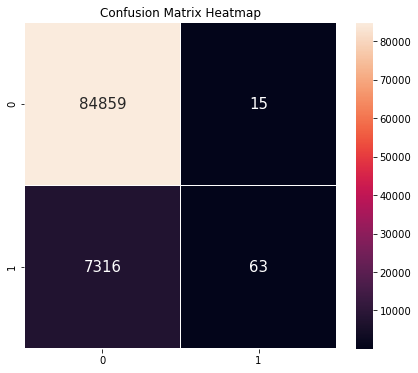

MSE :  0.07946625042004055
RMSE :  0.28189758853179386
Score Roc:  0.5041805048366093
Score de Rappel: 0.008537742241496138
Score de Precision: 0.8076923076923077

FBeta_Score:
Mesure F: 0.01689687541906933
Mesure F05: 0.04095696268365622
Mesure F2: 0.010644049469487058
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.07
Coût métier: 267853
Confusion Matrix of CV data:


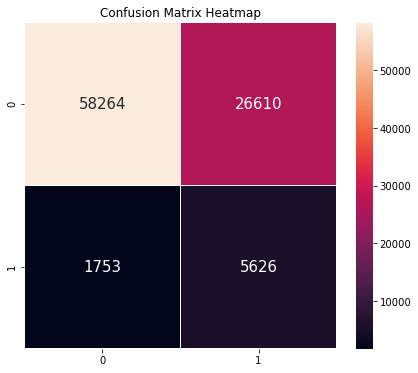

MSE :  0.30744799627112396
RMSE :  0.5544799331545949
Score Roc:  0.7244551790064044
Score de Rappel: 0.762433934137417
Score de Precision: 0.174525375356744

FBeta_Score:
Mesure F: 0.284033825571122
Mesure F05: 0.20634815841787518
Mesure F2: 0.4555318046379064
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.19
Coût métier: 71718
Confusion Matrix of CV data:


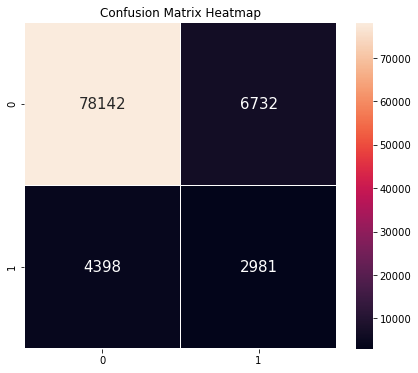

MSE :  0.12064648304120192
RMSE :  0.34734202602219316
Score Roc:  0.6623333515348372
Score de Rappel: 0.4039842797126982
Score de Precision: 0.30690826727066817

FBeta_Score:
Mesure F: 0.34881816054294407
Mesure F05: 0.32240271679176313
Mesure F2: 0.37994850748170994
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.22
Coût métier: 54852
Confusion Matrix of CV data:


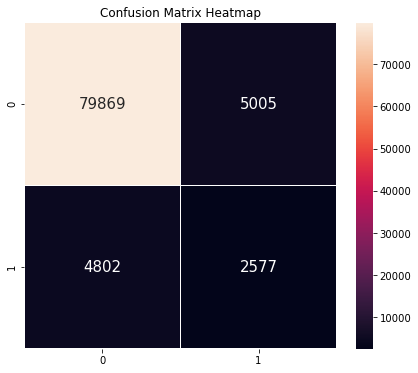

MSE :  0.10630548600045527
RMSE :  0.3260452207906984
Score Roc:  0.6451322733219872
Score de Rappel: 0.34923431359262774
Score de Precision: 0.33988393563703506

FBeta_Score:
Mesure F: 0.34449568879085624
Mesure F05: 0.34171374015434797
Mesure F2: 0.3473233058385897
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.94
Coût métier: 7378
Confusion Matrix of CV data:


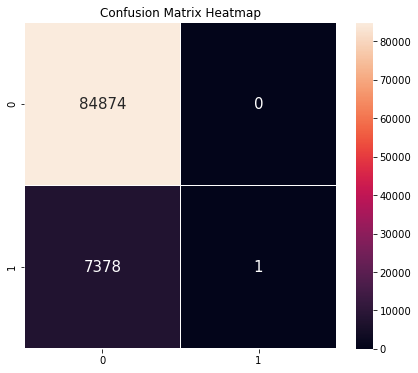

MSE :  0.07997571894680931
RMSE :  0.2827997859737686
Score Roc:  0.5000677598590595
Score de Rappel: 0.0001355197181189863
Score de Precision: 1.0

FBeta_Score:
Mesure F: 0.00027100271002710027
Mesure F05: 0.0006772314777190844
Mesure F2: 0.0001693939085950469
 
 #################################### Seuil aléatoire afin de comparer ############################################### 

Seuil:  0.4
Coût métier: 15310
Confusion Matrix of CV data:


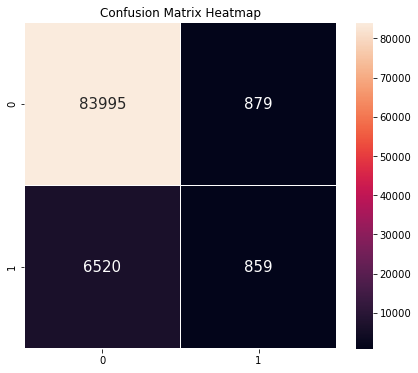

MSE :  0.08020335382047196
RMSE :  0.28320196648411883
Score Roc:  0.5530274546815684
Score de Rappel: 0.11641143786420924
Score de Precision: 0.4942462600690449

FBeta_Score:
Mesure F: 0.1884391795546781
Mesure F05: 0.2996999511548391
Mesure F2: 0.13742240993152874
 
 #################################### Seuil aléatoire afin de comparer ############################################### 



In [231]:
for seuil in listeSeuil:    
    print("Seuil: ", seuil)
    informationModeleSeuil(y_test, seuil)
    print(' \n #################################### Seuil aléatoire afin de comparer ############################################### \n')

In [236]:
y_predSeuil = np.zeros(y_predLgbmHPSeuil.shape)
y_predSeuil[y_predLgbmHPSeuil > 0.79] = 1
coutAReduire = coutMetier(y_test, y_predSeuil)

In [237]:
coutAReduire

7384

In [238]:
joblib.dump(y_predSeuil, r'C:\Users\Alexis\y_predSeuil.joblib')

['C:\\Users\\Alexis\\y_predSeuil.joblib']

Regardons les variables les plus importantes:

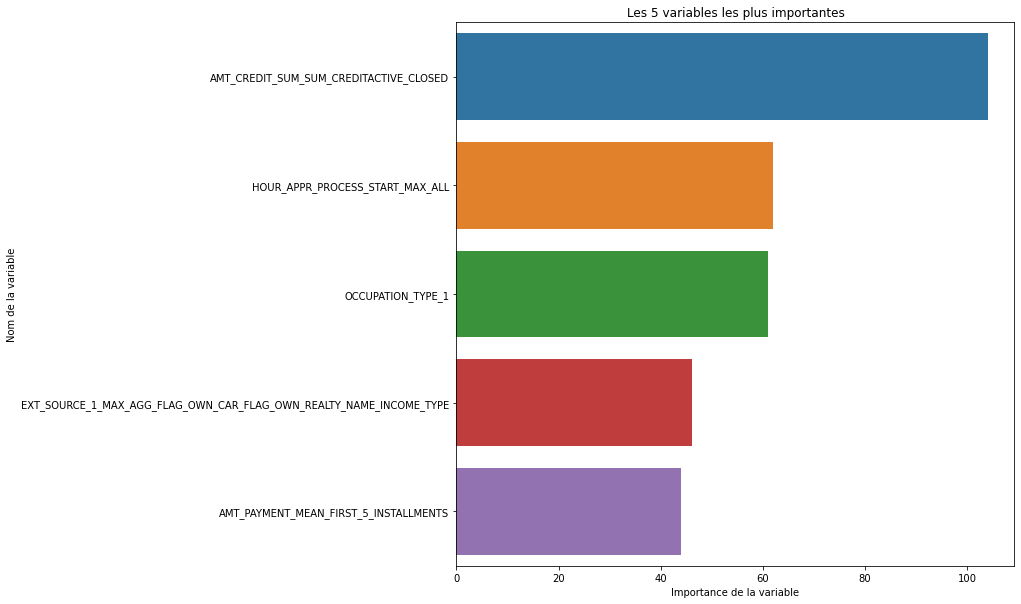

In [239]:
featureImportances = lgbmHPSeuil.feature_importances_
colonneDataframe = train_data.columns

topFeature = np.argsort(featureImportances)[::-1][:5]
topFeatureImportances = featureImportances[topFeature]
nomVariable = colonneDataframe[topFeatureImportances]
        
plt.figure(figsize = (10, 10)) 
sns.barplot(x = topFeatureImportances, y = list(range(5)), orient = 'h')
plt.yticks(list(range(5)), nomVariable)
plt.title('Les 5 variables les plus importantes')
plt.xlabel('Importance de la variable')
plt.ylabel('Nom de la variable')
plt.show()

### SHAP

In [ ]:
#!!! EXPLIQUER SHAP !!!

In [240]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [241]:
explainer = shap.TreeExplainer(lgbmGrid)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


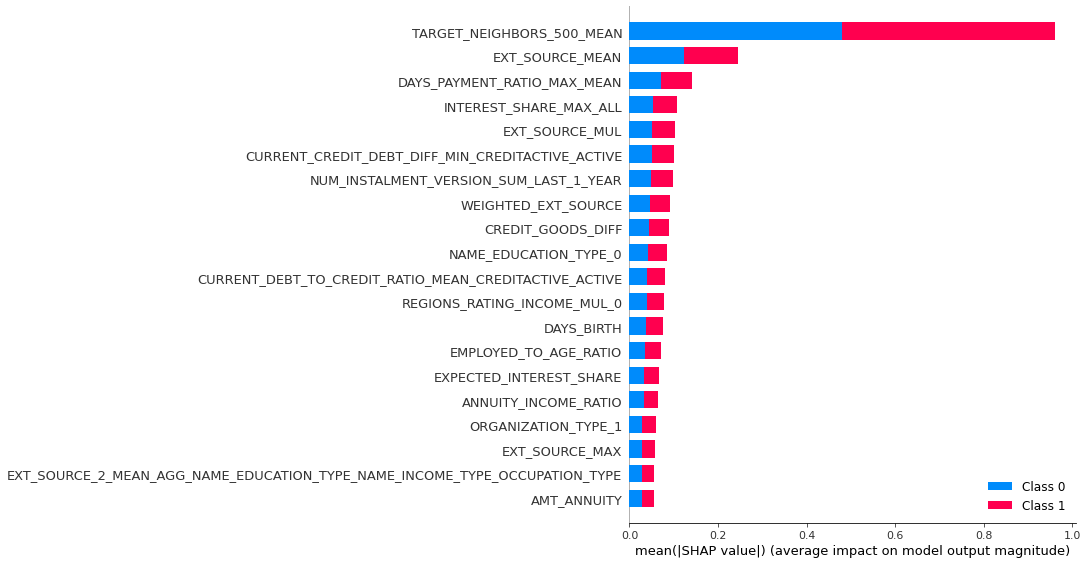

In [242]:
shap.summary_plot(shap_values, X_test)

In [243]:
#!!! variable descriptif du client (nbre enfant, valeur de prêt etc (oui on parle bien de ùmoi))
#!!! presenter les features les plus importantes

In [244]:
explainer.expected_value

[2.9369667543399736, -2.9369667543399736]

In [245]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[[0]])

### LIME

In [ ]:
#!!! EXPLIQUER LIME !!!

In [ ]:
#!pip install lime

In [246]:
import lime
from lime import lime_tabular

In [247]:
explainer = lime_tabular.LimeTabularExplainer(X_train.values, 
                feature_names = X_train.columns.values.tolist(),
                verbose = True,
                mode = "classification")

In [248]:
explainer

In [249]:
import random
idx = random.randint(1, len(X_test))

expLGBM = explainer.explain_instance(X_test.values[idx], lgbmGrid.predict_proba, num_features = len(X_test.columns.values.tolist()))
expLGBM.show_in_notebook(show_table=True)

Intercept 0.1590078112545325
Prediction_local [0.02238286]
Right: 0.01975235909109019
